⚡ ASR + Diarization — Using Faster-Whisper Engine

### Load Dependencies

In [9]:
# Install dependencies (jalankan jika belum terinstall)
!pip install faster-whisper librosa pyannote.audio ffmpeg-python jiwer pydub --quiet torch torchvision --index-url https://download.pytorch.org/whl/cu130


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Imports dasar
import os
import os
import glob
import librosa
import re
import torch
import json
import matplotlib.pyplot as plt

from faster_whisper import WhisperModel
import ffmpeg
from jiwer import wer, cer
from pyannote.audio import Pipeline

### Load Diarization And ASR Model

In [11]:
ASR_MODEL = "large-v3"  
DIARIZATION_MODEL = "pyannote/speaker-diarization-3.1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COMPUTE_TYPE = "float16" if DEVICE.startswith("cuda") else "float32"
PYANNOTE_TOKEN = os.environ.get("PYANNOTE_AUTH_TOKEN")

print("ASR Model: ", ASR_MODEL)
print("Diarization Model: ", DIARIZATION_MODEL)
print("Device:", DEVICE)
print("Compute type:", COMPUTE_TYPE)


ASR Model:  large-v3
Diarization Model:  pyannote/speaker-diarization-3.1
Device: cuda
Compute type: float16


In [12]:
try:
    model = WhisperModel(ASR_MODEL, device=DEVICE, compute_type=COMPUTE_TYPE)
    print(f"Loaded Whisper ASR model {ASR_MODEL} (default).")
except Exception as e:
    print("Gagal load default Whisper model, error:\n", e)

Loaded Whisper ASR model large-v3 (default).


In [13]:
if PYANNOTE_TOKEN is None:
    print("Warning: PYANNOTE_AUTH_TOKEN tidak ditemukan di environment. Pastikan sudah diset jika menggunakan HuggingFace/pyannote hosted pipeline.")

try:
    diarization_pipeline = Pipeline.from_pretrained(DIARIZATION_MODEL, token=PYANNOTE_TOKEN)
    print(f"Loaded pyannote diarization pipeline {DIARIZATION_MODEL} (default).")
except Exception as e:
    print("Gagal load default pyannote pipeline, error:\n", e)
    diarization_pipeline = None
    print("Pastikan kamu memiliki pipeline diarization yang valid atau set PYANNOTE_AUTH_TOKEN dan nama pipeline yang benar.")

Loaded pyannote diarization pipeline pyannote/speaker-diarization-3.1 (default).


### Validation using OpenLSR datasets

In [14]:
def extract_audio(video_path, audio_path="audio.wav"):
    (
        ffmpeg
        .input(video_path)
        .output(audio_path, ac=1, ar=16000)
        .overwrite_output()
        .run()
    )
    return audio_path

audio_file = extract_audio("interview_question_1.webm")

In [15]:
audio, sr = librosa.load(audio_file, sr=16000)
diarization = diarization_pipeline(audio_file)

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\pyannote\audio\models\blocks\pooling.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1857.)
  std = sequences.std(dim=-1, correction=1)


In [16]:
results = []

for turn, speaker in diarization.speaker_diarization:
    start = int(turn.start * sr)
    end = int(turn.end * sr)
    clip = audio[start:end]
    segments, info = model.transcribe(clip ,language="en", task="transcribe")
    transcription = " ".join([s.text for s in segments])
    results.append({
        "start": round(turn.start, 2),
        "end": round(turn.end, 2),
        "speaker": speaker,
        "text": transcription
    })

for line in results:
    print(line)

{'start': 1.36, 'end': 6.34, 'speaker': 'SPEAKER_00', 'text': ' Can you share any specific challenges you face while working on certification and how you overcome them?'}
{'start': 7.17, 'end': 11.73, 'speaker': 'SPEAKER_00', 'text': ' ah okay actually uh for this challenge just uh'}
{'start': 13.02, 'end': 25.33, 'speaker': 'SPEAKER_00', 'text': ' There are some challenges when I took the certifications, especially for the project submission that I will'}
{'start': 25.97, 'end': 31.67, 'speaker': 'SPEAKER_00', 'text': ' already working with it the first one is actually'}
{'start': 33.07, 'end': 33.88, 'speaker': 'SPEAKER_00', 'text': ' uh...'}
{'start': 33.95, 'end': 40.77, 'speaker': 'SPEAKER_00', 'text': ' to meet the specific accuracy or'}
{'start': 41.29, 'end': 49.68, 'speaker': 'SPEAKER_00', 'text': " violation laws right for the evaluation matrix and yeah actually that's just need to to"}
{'start': 50.15, 'end': 52.19, 'speaker': 'SPEAKER_00', 'text': ' to take some trial and e

In [17]:
def read_librispeech_reference(flac_path: str):
    utt_id = os.path.splitext(os.path.basename(flac_path))[0]
    chapter_dir = os.path.dirname(flac_path)

    spk, chap, _ = utt_id.split('-')
    trans_path = os.path.join(chapter_dir, f"{spk}-{chap}.trans.txt")

    if not os.path.exists(trans_path):
        candidates = glob.glob(os.path.join(chapter_dir, '*.trans.txt'))

        if not candidates:
            raise FileNotFoundError(f"trans.txt tidak ditemukan {flac_path}")
        trans_path = candidates[0]
    
    with open(trans_path, 'r') as f:
        for line in f:
            key, txt = line.strip().split(" ", 1)
            if key == utt_id:
                txt = txt.strip()

                if txt.startswith("(") and ") =" in txt:
                    right = txt.split(") = ", 1)[-1]
                    return right
                return txt
    
    raise ValueError(f"Tidak ada baris referensi utk {utt_id} di {trans_path}")

In [18]:
def normalize_text(s: str):
    s = s.lower()
    s = re.sub(r"[^\w\s]", "", s)          
    s = re.sub(r"\s+", " ", s).strip()    
    return s

In [19]:
def diar_asr_transcribe(audio, sr, diar_model, asr_model):
    """
    audio: numpy array (dari librosa load)
    sr: sampling rate (16000)
    """
    
    # Skip jika audio terlalu pendek (< 0.25 detik)
    if len(audio) < sr * 0.25:
        return "", []

    # Convert ke Tensor untuk Pyannote
    waveform = torch.tensor(audio, dtype=torch.float32).unsqueeze(0)

    # ---- A. DIARIZATION ----
    try:
        # Jalankan diarization pipeline
        diar = diar_model({"waveform": waveform, "sample_rate": sr})
    except Exception as e:
        print(f"[ERROR] Diarization failed: {e}")
        return "", []

    final_text_parts = []
    segments_info = []

    try:
        # Iterasi setiap segmen pembicara
        for turn, track, speaker in diar.speaker_diarization.itertracks(yield_label=True):
            
            start_sample = int(turn.start * sr)
            end_sample = int(turn.end * sr)

            if end_sample <= start_sample: continue

            # Potong audio berdasarkan timestamp diarization
            clip = audio[start_sample:end_sample]

            # Skip jika clip terlalu pendek (< 0.1 detik)
            if len(clip) < sr * 0.1: continue

            # ---- B. ASR pada Clip ----
            try:
                # PERBAIKAN: Gunakan 'clip', BUKAN 'audio' utuh
                # Convert clip ke float32 numpy array (standar whisper/librosa)
                segments, info = asr_model.transcribe(
                    clip, 
                    language="en",
                    task="transcribe"
                )
                
                # Handling output pipeline whisper (bisa beda versi transformers)
                # Output biasanya dict {'text': '...'} atau list of dicts
                hyp =  " ".join(s.text for s in segments)

            except Exception as e:
                print(f"[WARNING] ASR failed on segment {start_sample}-{end_sample}: {e}")
                continue

            if hyp:
                final_text_parts.append(hyp)
                segments_info.append({
                    "speaker": speaker,
                    "start": float(turn.start),
                    "end": float(turn.end),
                    "text": hyp
                })

    except Exception as e:
        print(f"[ERROR] Iterating segments failed: {e}")
        traceback.print_exc()
        return "", []

    full_transcription = " ".join(final_text_parts).strip()
    return full_transcription, segments_info

In [20]:
def evaluate_asr_diar_dataset(base_dir, diar_model, asr_model):
    """
    base_dir: Folder root dataset (local path)
    diar_model: Instance Pyannote
    asr_model: Instance Whisper Pipeline
    """
    
    # 1. Cari semua file FLAC secara rekursif
    print(f"Mencari file .flac di {base_dir}...")
    flac_files = glob.glob(os.path.join(base_dir, "**", "*.flac"), recursive=True)
    
    total_files = len(flac_files)
    print(f"Ditemukan {total_files} file audio.")

    wer_list = []
    cer_list = []
    details = []

    for idx, flac_path in enumerate(flac_files):
        print(f"[{idx+1}/{total_files}] Processing: {os.path.basename(flac_path)}")

        try:
            # --- A. Load Ground Truth ---
            try:
                ref = read_librispeech_reference(flac_path)
            except Exception as e:
                print(f"   [SKIP] Gagal baca referensi: {e}")
                continue
            
            if not ref.strip():
                print("   [SKIP] Referensi kosong.")
                continue

            # --- B. Load Audio (Librosa 16khz) ---
            # sr=16000 penting untuk Wav2Vec2/Whisper/Pyannote
            audio, sr = librosa.load(flac_path, sr=16000) 

            if audio is None or len(audio) == 0:
                print("   [SKIP] Audio kosong atau corrupt.")
                continue

            # --- C. Jalankan Diarization + ASR ---
            hyp_text, segs = diar_asr_transcribe(audio, sr, diar_model, asr_model)

            if not hyp_text:
                print("   [WARNING] Hipotesis kosong (Model tidak mendeteksi suara).")
                # Kita anggap hyp kosong string, WER akan tinggi tapi tidak error
                hyp_text = "" 

            # --- D. Hitung Metrics ---
            ref_n = normalize_text(ref)
            hyp_n = normalize_text(hyp_text)

            # Hitung WER/CER (menggunakan library jiwer)
            # Jika hyp kosong, WER = 1.0 (100% salah)
            if not hyp_n and ref_n:
                 w = 1.0
                 c = 1.0
            elif not ref_n:
                 w = 0.0 # Jika ref kosong dan hyp kosong dianggap benar
                 c = 0.0
            else:
                 w = wer(ref_n, hyp_n)
                 c = cer(ref_n, hyp_n)

            wer_list.append(w)
            cer_list.append(c)

            print(f"   -> WER: {w:.2f} | Ref: {ref_n[:30]}... | Hyp: {hyp_n[:30]}...")

            details.append({
                "file": flac_path,
                "ref": ref_n,
                "hyp": hyp_n,
                "wer": w,
                "cer": c,
                "segments": segs
            })

        except Exception as e:
            print(f"[ERROR] Fatal error pada file {flac_path}: {e}")
            traceback.print_exc()
            continue

    # --- 5. Hasil Akhir ---
    if not wer_list:
        return {"Error": "Tidak ada file yang berhasil divalidasi."}

    avg_wer = sum(wer_list) / len(wer_list)
    avg_cer = sum(cer_list) / len(cer_list)

    print("="*30)
    print(f"FINISHED. Avg WER: {avg_wer:.2%} | Avg CER: {avg_cer:.2%}")
    print("="*30)

    return {
        "Average WER": avg_wer,
        "Average CER": avg_cer,
        "Details": details,
        "Processed Files": len(wer_list)
    }

In [21]:
result = evaluate_asr_diar_dataset(
    base_dir = "./datasets",
    diar_model=diarization_pipeline,  
    asr_model=model
)

Mencari file .flac di ./datasets...
Ditemukan 2620 file audio.
[1/2620] Processing: 1089-134686-0000.flac
   -> WER: 0.00 | Ref: he hoped there would be stew f... | Hyp: he hoped there would be stew f...
[2/2620] Processing: 1089-134686-0001.flac
   -> WER: 0.12 | Ref: stuff it into you his belly co... | Hyp: stuff it into you his belly co...
[3/2620] Processing: 1089-134686-0002.flac
   -> WER: 0.00 | Ref: after early nightfall the yell... | Hyp: after early nightfall the yell...
[4/2620] Processing: 1089-134686-0003.flac
   -> WER: 0.00 | Ref: hello bertie any good in your ... | Hyp: hello bertie any good in your ...
[5/2620] Processing: 1089-134686-0004.flac
   -> WER: 0.09 | Ref: number ten fresh nelly is wait... | Hyp: number 10 fresh nelly is waiti...
[6/2620] Processing: 1089-134686-0005.flac
   -> WER: 0.00 | Ref: the music came nearer and he r... | Hyp: the music came nearer and he r...
[7/2620] Processing: 1089-134686-0006.flac
   -> WER: 0.04 | Ref: the dull light fell more 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: he could wait no longer... | Hyp: he could wait no longer...
[40/2620] Processing: 1089-134691-0001.flac
   -> WER: 0.00 | Ref: for a full hour he had paced u... | Hyp: for a full hour he had paced u...
[41/2620] Processing: 1089-134691-0002.flac
   -> WER: 0.00 | Ref: he set off abruptly for the bu... | Hyp: he set off abruptly for the bu...
[42/2620] Processing: 1089-134691-0003.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the university... | Hyp: the university...
[43/2620] Processing: 1089-134691-0004.flac
   -> WER: 0.00 | Ref: pride after satisfaction uplif... | Hyp: pride after satisfaction uplif...
[44/2620] Processing: 1089-134691-0005.flac
   -> WER: 0.08 | Ref: whose feet are as the feet of ... | Hyp: whose feet are as the feet of ...
[45/2620] Processing: 1089-134691-0006.flac
   -> WER: 0.00 | Ref: the pride of that dim image br... | Hyp: the pride of that dim image br...
[46/2620] Processing: 1089-134691-0007.flac
   -> WER: 0.00 | Ref: soon the whole bridge was trem... | Hyp: soon the whole bridge was trem...
[47/2620] Processing: 1089-134691-0008.flac
   -> WER: 0.00 | Ref: the uncouth faces passed him t... | Hyp: the uncouth faces passed him t...
[48/2620] Processing: 1089-134691-0009.flac
   -> WER: 0.12 | Ref: angry with himself he tried to... | Hyp: thank you angry with himself h...
[49/2620] Processing: 1089-134691-0010.flac
   -> WER: 0.60 | Ref: brother mac ard

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 1.00 | Ref: stephanos dedalos... | Hyp: stefanos derlos...
[64/2620] Processing: 1089-134691-0025.flac
   -> WER: 0.00 | Ref: a moment before the ghost of t... | Hyp: a moment before the ghost of t...
[65/2620] Processing: 1188-133604-0000.flac
   -> WER: 0.05 | Ref: you will find me continually s... | Hyp: you will find me continually s...
[66/2620] Processing: 1188-133604-0001.flac
   -> WER: 0.11 | Ref: they unite every quality and s... | Hyp: thank you they unite every qua...
[67/2620] Processing: 1188-133604-0002.flac
   -> WER: 0.00 | Ref: by being studious of color the... | Hyp: by being studious of color the...
[68/2620] Processing: 1188-133604-0003.flac
   -> WER: 0.03 | Ref: my first and principal reason ... | Hyp: my first and principal reason ...
[69/2620] Processing: 1188-133604-0004.flac
   -> WER: 0.00 | Ref: some of the touches indeed whe... | Hyp: some of the touches indeed whe...
[70/2620] Processing: 1188-133604-0005.flac
   -> WER: 0.03 | Ref: it is the h

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: then he comes to the beak of i... | Hyp: then he comes to the beak of i...
[72/2620] Processing: 1188-133604-0007.flac
   -> WER: 0.02 | Ref: the brown ground beneath is le... | Hyp: the brown ground beneath is le...
[73/2620] Processing: 1188-133604-0008.flac
   -> WER: 0.05 | Ref: for believe me the final philo... | Hyp: for believe me the final philo...
[74/2620] Processing: 1188-133604-0009.flac
   -> WER: 0.01 | Ref: now you will see in these stud... | Hyp: now you will see in these stud...
[75/2620] Processing: 1188-133604-0010.flac
   -> WER: 0.00 | Ref: but in this vignette copied fr... | Hyp: but in this vignette copied fr...
[76/2620] Processing: 1188-133604-0011.flac
   -> WER: 0.00 | Ref: they are beyond all other work... | Hyp: they are beyond all other work...
[77/2620] Processing: 1188-133604-0012.flac
   -> WER: 0.00 | Ref: it may be that a great coloris... | Hyp: it may be that a great coloris...
[78/2620] Processing: 1188-133604-0013.flac
   -> 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: he knows them both... | Hyp: he knows them both...
[96/2620] Processing: 1188-133604-0031.flac
   -> WER: 0.00 | Ref: theres one and theres another ... | Hyp: theres one and theres another ...
[97/2620] Processing: 1188-133604-0032.flac
   -> WER: 0.07 | Ref: it is only a pencil outline by... | Hyp: it is only a pencil outline by...
[98/2620] Processing: 1188-133604-0033.flac
   -> WER: 0.00 | Ref: every plant in the grass is se... | Hyp: every plant in the grass is se...
[99/2620] Processing: 1188-133604-0034.flac
   -> WER: 0.02 | Ref: exquisite order and universal ... | Hyp: exquisite order and universal ...
[100/2620] Processing: 1188-133604-0035.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: thus in chaucers dream... | Hyp: thus in chaucers dream...
[101/2620] Processing: 1188-133604-0036.flac
   -> WER: 0.12 | Ref: in both these high mythical su... | Hyp: thank you in both these high m...
[102/2620] Processing: 1188-133604-0037.flac
   -> WER: 0.03 | Ref: every line in which the master... | Hyp: every line in which the master...
[103/2620] Processing: 1188-133604-0038.flac
   -> WER: 0.05 | Ref: but now here is a subject of w... | Hyp: but now here is the subject of...
[104/2620] Processing: 1188-133604-0039.flac
   -> WER: 0.00 | Ref: it has no beauty whatsoever no... | Hyp: it has no beauty whatsoever no...
[105/2620] Processing: 1188-133604-0040.flac
   -> WER: 0.00 | Ref: the crampness and the poverty ... | Hyp: the crampness and the poverty ...
[106/2620] Processing: 1188-133604-0041.flac
   -> WER: 0.07 | Ref: it is a gleaner bringing down ... | Hyp: it is a gleaner bringing down ...
[107/2620] Processing: 1188-133604-0042.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the scene is absolutely arcadi... | Hyp: the scene is absolutely arcadi...
[108/2620] Processing: 1188-133604-0043.flac
   -> WER: 0.00 | Ref: see that your lives be in noth... | Hyp: see that your lives be in noth...
[109/2620] Processing: 1188-133604-0044.flac
   -> WER: 0.02 | Ref: it will be well for you if you... | Hyp: it will be well for you if you...
[110/2620] Processing: 121-121726-0000.flac
   -> WER: 0.12 | Ref: also a popular contrivance whe... | Hyp: also a popular contrivance whe...
[111/2620] Processing: 121-121726-0001.flac
   -> WER: 0.00 | Ref: harangue the tiresome product ... | Hyp: harangue the tiresome product ...
[112/2620] Processing: 121-121726-0002.flac
   -> WER: 0.00 | Ref: angor pain painful to hear... | Hyp: angor pain painful to hear...
[113/2620] Processing: 121-121726-0003.flac
   -> WER: 0.07 | Ref: hay fever a heart trouble caus... | Hyp: hey fever a heart trouble caus...
[114/2620] Processing: 121-121726-0004.flac
   -> WER: 0

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: tied to a woman... | Hyp: tied to a woman...
[124/2620] Processing: 121-121726-0014.flac
   -> WER: 0.50 | Ref: hypocrite a horse dealer... | Hyp: hypocrite a horsedealer...
[125/2620] Processing: 121-123852-0000.flac
   -> WER: 0.07 | Ref: those pretty wrongs that liber... | Hyp: those pretty wrongs that liber...
[126/2620] Processing: 121-123852-0001.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 1.50 | Ref: ay me... | Hyp: im me thank you...
[127/2620] Processing: 121-123852-0002.flac
   -> WER: 0.03 | Ref: no matter then although my foo... | Hyp: no matter then although my foo...
[128/2620] Processing: 121-123852-0003.flac
   -> WER: 0.00 | Ref: thought kills me that i am not... | Hyp: thought kills me that i am not...
[129/2620] Processing: 121-123852-0004.flac
   -> WER: 0.03 | Ref: my heart doth plead that thou ... | Hyp: my heart doth plead that thou ...
[130/2620] Processing: 121-123859-0000.flac
   -> WER: 0.03 | Ref: you are my all the world and i... | Hyp: you are my all the world and i...
[131/2620] Processing: 121-123859-0001.flac
   -> WER: 0.08 | Ref: o tis the first tis flattery i... | Hyp: thank you oh tis the first tis...
[132/2620] Processing: 121-123859-0002.flac
   -> WER: 0.07 | Ref: but reckoning time whose milli... | Hyp: but reckoning time whose milli...
[133/2620] Processing: 121-123859-0003.flac
   -> WER: 0.00 | Ref: love is a babe then mig

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the storys written... | Hyp: the storys written...
[140/2620] Processing: 121-127105-0005.flac
   -> WER: 0.00 | Ref: i could write to my man and en... | Hyp: i could write to my man and en...
[141/2620] Processing: 121-127105-0006.flac
   -> WER: 0.00 | Ref: the others resented postponeme... | Hyp: the others resented postponeme...
[142/2620] Processing: 121-127105-0007.flac
   -> WER: 0.00 | Ref: to this his answer was prompt ... | Hyp: to this his answer was prompt ...
[143/2620] Processing: 121-127105-0008.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: he hung fire again a womans... | Hyp: he hung fire again a womans...
[144/2620] Processing: 121-127105-0009.flac
   -> WER: 0.14 | Ref: she has been dead these twenty... | Hyp: she has been dead these 20 yea...
[145/2620] Processing: 121-127105-0010.flac
   -> WER: 0.20 | Ref: she sent me the pages in quest... | Hyp: she sent me the pages in quest...
[146/2620] Processing: 121-127105-0011.flac
   -> WER: 0.00 | Ref: she was the most agreeable wom... | Hyp: she was the most agreeable wom...
[147/2620] Processing: 121-127105-0012.flac
   -> WER: 0.00 | Ref: it wasnt simply that she said ... | Hyp: it wasnt simply that she said ...
[148/2620] Processing: 121-127105-0013.flac
   -> WER: 0.00 | Ref: youll easily judge why when yo... | Hyp: youll easily judge why when yo...
[149/2620] Processing: 121-127105-0014.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: you are acute... | Hyp: you are acute...
[150/2620] Processing: 121-127105-0015.flac
   -> WER: 0.00 | Ref: he quitted the fire and droppe... | Hyp: he quitted the fire and droppe...
[151/2620] Processing: 121-127105-0016.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: probably not till the second p... | Hyp: probably not till the second p...
[152/2620] Processing: 121-127105-0017.flac
   -> WER: 0.00 | Ref: it was almost the tone of hope... | Hyp: it was almost the tone of hope...
[153/2620] Processing: 121-127105-0018.flac
   -> WER: 0.00 | Ref: cried the ladies whose departu... | Hyp: cried the ladies whose departu...
[154/2620] Processing: 121-127105-0019.flac
   -> WER: 0.09 | Ref: missus griffin however express... | Hyp: mrs griffin however expressed ...
[155/2620] Processing: 121-127105-0020.flac
   -> WER: 0.00 | Ref: who was it she was in love wit... | Hyp: who was it she was in love wit...
[156/2620] Processing: 121-127105-0021.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: wont you tell douglas... | Hyp: wont you tell douglas...
[157/2620] Processing: 121-127105-0022.flac
   -> WER: 0.00 | Ref: well if i dont know who she wa... | Hyp: well if i dont know who she wa...
[158/2620] Processing: 121-127105-0023.flac
   -> WER: 0.00 | Ref: let me say here distinctly to ... | Hyp: let me say here distinctly to ...
[159/2620] Processing: 121-127105-0024.flac
   -> WER: 0.02 | Ref: poor douglas before his death ... | Hyp: poor douglas before his death ...
[160/2620] Processing: 121-127105-0025.flac
   -> WER: 0.00 | Ref: the departing ladies who had s... | Hyp: the departing ladies who had s...
[161/2620] Processing: 121-127105-0026.flac
   -> WER: 0.00 | Ref: the first of these touches con... | Hyp: the first of these touches con...
[162/2620] Processing: 121-127105-0027.flac
   -> WER: 0.00 | Ref: he had for his own town reside... | Hyp: he had for his own town reside...
[163/2620] Processing: 121-127105-0028.flac
   -> WER: 0.00 | Ref: t

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: it was the beauty of it... | Hyp: it was the beauty of it...
[169/2620] Processing: 121-127105-0034.flac
   -> WER: 0.06 | Ref: it sounded dull it sounded str... | Hyp: it sounded dull that sounded s...
[170/2620] Processing: 121-127105-0035.flac
   -> WER: 0.00 | Ref: she promised to do this and sh... | Hyp: she promised to do this and sh...
[171/2620] Processing: 121-127105-0036.flac
   -> WER: 0.00 | Ref: but was that all her reward on... | Hyp: but was that all her reward on...
[172/2620] Processing: 1221-135766-0000.flac
   -> WER: 0.00 | Ref: how strange it seemed to the s... | Hyp: how strange it seemed to the s...
[173/2620] Processing: 1221-135766-0001.flac
   -> WER: 0.06 | Ref: god as a direct consequence of... | Hyp: god as a direct consequence of...
[174/2620] Processing: 1221-135766-0002.flac
   -> WER: 0.00 | Ref: yet these thoughts affected he... | Hyp: yet these thoughts affected he...
[175/2620] Processing: 1221-135766-0003.flac
   -> WER: 0.11 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the woman seemed thoughtful... | Hyp: the woman seemed thoughtful...
[230/2620] Processing: 1284-1180-0017.flac
   -> WER: 0.00 | Ref: at one end stood a great firep... | Hyp: at one end stood a great firep...
[231/2620] Processing: 1284-1180-0018.flac
   -> WER: 0.02 | Ref: it takes me several years to m... | Hyp: it takes me several years to m...
[232/2620] Processing: 1284-1180-0019.flac
   -> WER: 0.10 | Ref: you must know said margolotte ... | Hyp: well be right back you must kn...
[233/2620] Processing: 1284-1180-0020.flac
   -> WER: 0.00 | Ref: the first lot we tested on our... | Hyp: the first lot we tested on our...
[234/2620] Processing: 1284-1180-0021.flac
   -> WER: 0.06 | Ref: i think the next glass cat the... | Hyp: i think the next glass cap a m...
[235/2620] Processing: 1284-1180-0022.flac
   -> WER: 0.00 | Ref: im afraid i dont know much abo... | Hyp: im afraid i dont know much abo...
[236/2620] Processing: 1284-1180-0023.flac
   -> WER: 0.05 | R

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: will the hurons hear his groan... | Hyp: will the hurons hear his groan...
[332/2620] Processing: 1320-122617-0039.flac
   -> WER: 0.00 | Ref: the mohican started on his fee... | Hyp: the mohican started on his fee...
[333/2620] Processing: 1320-122617-0040.flac
   -> WER: 0.00 | Ref: he had no occasion to delay fo... | Hyp: he had no occasion to delay fo...
[334/2620] Processing: 1320-122617-0041.flac
   -> WER: 0.00 | Ref: uncas cast his skin and steppe... | Hyp: uncas cast his skin and steppe...
[335/2620] Processing: 1580-141083-0000.flac
   -> WER: 0.03 | Ref: i will endeavour in my stateme... | Hyp: i will endeavor in my statemen...
[336/2620] Processing: 1580-141083-0001.flac
   -> WER: 0.00 | Ref: i had always known him to be r... | Hyp: i had always known him to be r...
[337/2620] Processing: 1580-141083-0002.flac
   -> WER: 0.00 | Ref: my friends temper had not impr... | Hyp: my friends temper had not impr...
[338/2620] Processing: 1580-141083-0003.flac

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: so it seems to me... | Hyp: so it seems to me...
[353/2620] Processing: 1580-141083-0018.flac
   -> WER: 0.17 | Ref: now mister soames at your disp... | Hyp: now mr soames at your disposal...
[354/2620] Processing: 1580-141083-0019.flac
   -> WER: 0.00 | Ref: above were three students one ... | Hyp: above were three students one ...
[355/2620] Processing: 1580-141083-0020.flac
   -> WER: 0.00 | Ref: then he approached it and stan... | Hyp: then he approached it and stan...
[356/2620] Processing: 1580-141083-0021.flac
   -> WER: 0.00 | Ref: there is no opening except the... | Hyp: there is no opening except the...
[357/2620] Processing: 1580-141083-0022.flac
   -> WER: 0.00 | Ref: i am afraid there are no signs... | Hyp: i am afraid there are no signs...
[358/2620] Processing: 1580-141083-0023.flac
   -> WER: 0.00 | Ref: one could hardly hope for any ... | Hyp: one could hardly hope for any ...
[359/2620] Processing: 1580-141083-0024.flac
   -> WER: 0.00 | Ref: yo

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: anyone in the room could get o... | Hyp: anyone in the room could get o...
[385/2620] Processing: 1580-141083-0050.flac
   -> WER: 0.09 | Ref: i really dont think he knew mu... | Hyp: i really dont think he knew mu...
[386/2620] Processing: 1580-141083-0051.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: only for a minute or so... | Hyp: only for a minute or so...
[387/2620] Processing: 1580-141083-0052.flac
   -> WER: 0.00 | Ref: oh i would not venture to say ... | Hyp: oh i would not venture to say ...
[388/2620] Processing: 1580-141083-0053.flac
   -> WER: 0.00 | Ref: you havent seen any of them no... | Hyp: you havent seen any of them no...
[389/2620] Processing: 1580-141084-0000.flac
   -> WER: 0.00 | Ref: it was the indian whose dark s... | Hyp: it was the indian whose dark s...
[390/2620] Processing: 1580-141084-0001.flac
   -> WER: 0.00 | Ref: he was pacing swiftly up and d... | Hyp: he was pacing swiftly up and d...
[391/2620] Processing: 1580-141084-0002.flac
   -> WER: 0.00 | Ref: this set of rooms is quite the... | Hyp: this set of rooms is quite the...
[392/2620] Processing: 1580-141084-0003.flac
   -> WER: 0.00 | Ref: no names please said holmes as... | Hyp: no names please said holmes as...
[393/2620] Processing: 1580-141084-0004.flac
   -> WER: 0.

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: that is very important said ho... | Hyp: that is very important said ho...
[395/2620] Processing: 1580-141084-0006.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: you dont seem to realize the p... | Hyp: you dont seem to realize the p...
[396/2620] Processing: 1580-141084-0007.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.40 | Ref: to morrow is the examination... | Hyp: tomorrow is the examination...
[397/2620] Processing: 1580-141084-0008.flac
   -> WER: 0.00 | Ref: i cannot allow the examination... | Hyp: i cannot allow the examination...
[398/2620] Processing: 1580-141084-0009.flac
   -> WER: 0.00 | Ref: it is possible that i may be i... | Hyp: it is possible that i may be i...
[399/2620] Processing: 1580-141084-0010.flac
   -> WER: 0.14 | Ref: i will take the black clay wit... | Hyp: i will take the black clay wit...
[400/2620] Processing: 1580-141084-0011.flac
   -> WER: 0.00 | Ref: when we were out in the darkne... | Hyp: when we were out in the darkne...
[401/2620] Processing: 1580-141084-0012.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.29 | Ref: the foul mouthed fellow at the... | Hyp: the foulmouthed fellow at the ...
[402/2620] Processing: 1580-141084-0013.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: he is the one with the worst r... | Hyp: he is the one with the worst r...
[403/2620] Processing: 1580-141084-0014.flac
   -> WER: 0.00 | Ref: why bannister the servant what... | Hyp: why bannister the servant what...
[404/2620] Processing: 1580-141084-0015.flac
   -> WER: 0.00 | Ref: he impressed me as being a per... | Hyp: he impressed me as being a per...
[405/2620] Processing: 1580-141084-0016.flac
   -> WER: 0.11 | Ref: my friend did not appear to be... | Hyp: my friend did not appear to be...
[406/2620] Processing: 1580-141084-0017.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: no good my dear watson... | Hyp: no good my dear watson...
[407/2620] Processing: 1580-141084-0018.flac
   -> WER: 0.00 | Ref: i think so you have formed a c... | Hyp: i think so you have formed a c...
[408/2620] Processing: 1580-141084-0019.flac
   -> WER: 0.00 | Ref: yes my dear watson i have solv... | Hyp: yes my dear watson i have solv...
[409/2620] Processing: 1580-141084-0020.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: look at that he held out his h... | Hyp: look at that he held out his h...
[410/2620] Processing: 1580-141084-0021.flac
   -> WER: 0.00 | Ref: on the palm were three little ... | Hyp: on the palm were three little ...
[411/2620] Processing: 1580-141084-0022.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: and one more this morning... | Hyp: and one more this morning...
[412/2620] Processing: 1580-141084-0023.flac
   -> WER: 0.00 | Ref: in a few hours the examination... | Hyp: in a few hours the examination...
[413/2620] Processing: 1580-141084-0024.flac
   -> WER: 0.00 | Ref: he could hardly stand still so... | Hyp: he could hardly stand still so...
[414/2620] Processing: 1580-141084-0025.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: you know him i think so... | Hyp: you know him i think so...
[415/2620] Processing: 1580-141084-0026.flac
   -> WER: 0.09 | Ref: if this matter is not to becom... | Hyp: if this matter is not to becom...
[416/2620] Processing: 1580-141084-0027.flac
   -> WER: 0.00 | Ref: no sir certainly not... | Hyp: no sir certainly not...
[417/2620] Processing: 1580-141084-0028.flac
   -> WER: 0.00 | Ref: there was no man sir... | Hyp: there was no man sir...
[418/2620] Processing: 1580-141084-0029.flac
   -> WER: 0.00 | Ref: his troubled blue eyes glanced... | Hyp: his troubled blue eyes glanced...
[419/2620] Processing: 1580-141084-0030.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: just close the door said holme... | Hyp: just close the door said holme...
[420/2620] Processing: 1580-141084-0031.flac
   -> WER: 0.09 | Ref: we want to know mister gilchri... | Hyp: we want to know mr gilchrist h...
[421/2620] Processing: 1580-141084-0032.flac
   -> WER: 0.00 | Ref: for a moment gilchrist with up... | Hyp: for a moment gilchrist with up...
[422/2620] Processing: 1580-141084-0033.flac
   -> WER: 0.00 | Ref: come come said holmes kindly i... | Hyp: come come said holmes kindly i...
[423/2620] Processing: 1580-141084-0034.flac
   -> WER: 0.00 | Ref: well well dont trouble to answ... | Hyp: well well dont trouble to answ...
[424/2620] Processing: 1580-141084-0035.flac
   -> WER: 0.00 | Ref: he could examine the papers in... | Hyp: he could examine the papers in...
[425/2620] Processing: 1580-141084-0036.flac
   -> WER: 0.00 | Ref: the indian i also thought noth... | Hyp: the indian i also thought noth...
[426/2620] Processing: 1580-141084-0037.flac

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: he put his shoes on the table... | Hyp: he put his shoes on the table...
[433/2620] Processing: 1580-141084-0044.flac
   -> WER: 0.00 | Ref: gloves said the young man... | Hyp: gloves said the young man...
[434/2620] Processing: 1580-141084-0045.flac
   -> WER: 0.00 | Ref: suddenly he heard him at the v... | Hyp: suddenly he heard him at the v...
[435/2620] Processing: 1580-141084-0046.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.14 | Ref: have i told the truth mister g... | Hyp: have i told the truth mr gilch...
[436/2620] Processing: 1580-141084-0047.flac
   -> WER: 0.05 | Ref: i have a letter here mister so... | Hyp: i have a letter here mr soames...
[437/2620] Processing: 1580-141084-0048.flac
   -> WER: 0.00 | Ref: it will be clear to you from w... | Hyp: it will be clear to you from w...
[438/2620] Processing: 1580-141084-0049.flac
   -> WER: 0.00 | Ref: it was simple enough sir if yo... | Hyp: it was simple enough sir if yo...
[439/2620] Processing: 1580-141084-0050.flac
   -> WER: 0.11 | Ref: if mister soames saw them the ... | Hyp: if mr soames saw them the game...
[440/2620] Processing: 1995-1826-0000.flac
   -> WER: 0.07 | Ref: in the debate between the seni... | Hyp: in the debate between the seni...
[441/2620] Processing: 1995-1826-0001.flac
   -> WER: 0.00 | Ref: the south she had not thought ... | Hyp: the south she had not thought ...
[442/2620] Processing: 1995-1826-0002.flac
   ->

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: at any rate i say go... | Hyp: at any rate i say go...
[451/2620] Processing: 1995-1826-0011.flac
   -> WER: 0.00 | Ref: here she was teaching dirty ch... | Hyp: here she was teaching dirty ch...
[452/2620] Processing: 1995-1826-0012.flac
   -> WER: 0.00 | Ref: she wanted a glance of the new... | Hyp: she wanted a glance of the new...
[453/2620] Processing: 1995-1826-0013.flac
   -> WER: 0.07 | Ref: so for the hundredth time she ... | Hyp: thank you so for the hundredth...
[454/2620] Processing: 1995-1826-0014.flac
   -> WER: 0.00 | Ref: cotton she paused... | Hyp: cotton she paused...
[455/2620] Processing: 1995-1826-0015.flac
   -> WER: 0.00 | Ref: she had almost forgotten that ... | Hyp: she had almost forgotten that ...
[456/2620] Processing: 1995-1826-0016.flac
   -> WER: 0.00 | Ref: the glimmering sea of delicate... | Hyp: the glimmering sea of delicate...
[457/2620] Processing: 1995-1826-0017.flac
   -> WER: 0.00 | Ref: there might be a bit of poetry... | 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: where was the use of imagining... | Hyp: where was the use of imagining...
[491/2620] Processing: 1995-1837-0009.flac
   -> WER: 0.08 | Ref: the lagoon had been level with... | Hyp: the lagoon had been level with...
[492/2620] Processing: 1995-1837-0010.flac
   -> WER: 0.00 | Ref: perhaps she too might be there... | Hyp: perhaps she too might be there...
[493/2620] Processing: 1995-1837-0011.flac
   -> WER: 0.00 | Ref: he started at the thought he h... | Hyp: he started at the thought he h...
[494/2620] Processing: 1995-1837-0012.flac
   -> WER: 0.00 | Ref: he splashed and stamped along ... | Hyp: he splashed and stamped along ...
[495/2620] Processing: 1995-1837-0013.flac
   -> WER: 0.00 | Ref: then he looked down the lagoon... | Hyp: then he looked down the lagoon...
[496/2620] Processing: 1995-1837-0014.flac
   -> WER: 0.00 | Ref: he stood a moment bewildered t... | Hyp: he stood a moment bewildered t...
[497/2620] Processing: 1995-1837-0015.flac
   -> WER: 0.

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.29 | Ref: and what through the left hand... | Hyp: and what through the lefthand ...
[517/2620] Processing: 2094-142345-0005.flac
   -> WER: 0.05 | Ref: several clothes horses a pilli... | Hyp: several clothes horses a pilli...
[518/2620] Processing: 2094-142345-0006.flac
   -> WER: 0.00 | Ref: at the edge of this box there ... | Hyp: at the edge of this box there ...
[519/2620] Processing: 2094-142345-0007.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the history of the house is pl... | Hyp: the history of the house is pl...
[520/2620] Processing: 2094-142345-0008.flac
   -> WER: 0.02 | Ref: but there is always a stronger... | Hyp: but there is always a stronger...
[521/2620] Processing: 2094-142345-0009.flac
   -> WER: 0.11 | Ref: for the great barn doors are t... | Hyp: where the great barn doors are...
[522/2620] Processing: 2094-142345-0010.flac
   -> WER: 0.05 | Ref: hetty sorrel often took the op... | Hyp: hetty searle often took the op...
[523/2620] Processing: 2094-142345-0011.flac
   -> WER: 0.28 | Ref: do not suppose however that mi... | Hyp: do not suppose however that mr...
[524/2620] Processing: 2094-142345-0012.flac
   -> WER: 0.00 | Ref: the family likeness between he... | Hyp: the family likeness between he...
[525/2620] Processing: 2094-142345-0013.flac
   -> WER: 0.00 | Ref: her tongue was not less keen t... | Hyp: her tongue was not less keen t...
[526/2620] Processing: 2094-142345-0014.flac

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: spinning indeed... | Hyp: spinning indeed...
[529/2620] Processing: 2094-142345-0017.flac
   -> WER: 0.00 | Ref: i never knew your equals for g... | Hyp: i never knew your equals for g...
[530/2620] Processing: 2094-142345-0018.flac
   -> WER: 0.00 | Ref: who taught you to scrub a floo... | Hyp: who taught you to scrub a floo...
[531/2620] Processing: 2094-142345-0019.flac
   -> WER: 0.14 | Ref: comb the wool for the whittaws... | Hyp: comb the wool for the widows i...
[532/2620] Processing: 2094-142345-0020.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: thats what youd like to be doi... | Hyp: thats what youd like to be doi...
[533/2620] Processing: 2094-142345-0021.flac
   -> WER: 0.00 | Ref: thats the way with you thats t... | Hyp: thats the way with you thats t...
[534/2620] Processing: 2094-142345-0022.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.67 | Ref: mister ottleys indeed... | Hyp: mr oatleys indeed...
[535/2620] Processing: 2094-142345-0023.flac
   -> WER: 0.21 | Ref: youre a rare un for sitting do... | Hyp: you are a rarin for sitting do...
[536/2620] Processing: 2094-142345-0024.flac
   -> WER: 0.27 | Ref: munny my irons twite told peas... | Hyp: money my irons twight told ple...
[537/2620] Processing: 2094-142345-0025.flac
   -> WER: 0.00 | Ref: cold is it my darling bless yo... | Hyp: cold is it my darling bless yo...
[538/2620] Processing: 2094-142345-0026.flac
   -> WER: 0.00 | Ref: shes going to put the ironing ... | Hyp: shes going to put the ironing ...
[539/2620] Processing: 2094-142345-0027.flac
   -> WER: 0.40 | Ref: munny i tould ike to do into d... | Hyp: money i did like to do into th...
[540/2620] Processing: 2094-142345-0028.flac
   -> WER: 0.19 | Ref: no no no totty ud get her feet... | Hyp: no no no toddyd get her feet w...
[541/2620] Processing: 2094-142345-0029.flac
   -> WER: 0.05 | Ref

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i didnt preach without directi... | Hyp: i didnt preach without directi...
[553/2620] Processing: 2094-142345-0041.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: direction... | Hyp: direction...
[554/2620] Processing: 2094-142345-0042.flac
   -> WER: 0.33 | Ref: i hanna common patience with y... | Hyp: i had a common patience with y...
[555/2620] Processing: 2094-142345-0043.flac
   -> WER: 0.00 | Ref: by this time the two gentlemen... | Hyp: by this time the two gentlemen...
[556/2620] Processing: 2094-142345-0044.flac
   -> WER: 0.29 | Ref: said mister irwine with his st... | Hyp: said mr irwin with his stately...
[557/2620] Processing: 2094-142345-0045.flac
   -> WER: 0.12 | Ref: oh sir dont mention it said mi... | Hyp: oh sir dont mention it said mr...
[558/2620] Processing: 2094-142345-0046.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.20 | Ref: i delight in your kitchen... | Hyp: my delight in your kitchen...
[559/2620] Processing: 2094-142345-0047.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: poyser is not at home is he... | Hyp: poyser is not at home is he...
[560/2620] Processing: 2094-142345-0048.flac
   -> WER: 0.06 | Ref: said captain donnithorne seati... | Hyp: said captain donnythorne seati...
[561/2620] Processing: 2094-142345-0049.flac
   -> WER: 0.12 | Ref: no sir he isnt hes gone to ros... | Hyp: no sir he isnt hes gone to ros...
[562/2620] Processing: 2094-142345-0050.flac
   -> WER: 0.08 | Ref: but theres father the barn sir... | Hyp: but theres father in the barn ...
[563/2620] Processing: 2094-142345-0051.flac
   -> WER: 0.00 | Ref: no thank you ill just look at ... | Hyp: no thank you ill just look at ...
[564/2620] Processing: 2094-142345-0052.flac
   -> WER: 0.00 | Ref: i must come another day and se... | Hyp: i must come another day and se...
[565/2620] Processing: 2094-142345-0053.flac
   -> WER: 0.00 | Ref: for if hes anywhere on the far... | Hyp: for if hes anywhere on the far...
[566/2620] Processing: 2094-142345-0054.flac
   ->

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the problem was solved... | Hyp: the problem was solved...
[613/2620] Processing: 2300-131720-0040.flac
   -> WER: 0.00 | Ref: we were more interested in the... | Hyp: we were more interested in the...
[614/2620] Processing: 2300-131720-0041.flac
   -> WER: 0.00 | Ref: we had meters in which there w... | Hyp: we had meters in which there w...
[615/2620] Processing: 237-126133-0000.flac
   -> WER: 0.00 | Ref: here she would stay comforted ... | Hyp: here she would stay comforted ...
[616/2620] Processing: 237-126133-0001.flac
   -> WER: 0.00 | Ref: every chance she could steal a... | Hyp: every chance she could steal a...
[617/2620] Processing: 237-126133-0002.flac
   -> WER: 0.03 | Ref: then dear said missus whitney ... | Hyp: then dear said mrs whitney you...
[618/2620] Processing: 237-126133-0003.flac
   -> WER: 0.00 | Ref: somehow of all the days when t... | Hyp: somehow of all the days when t...
[619/2620] Processing: 237-126133-0004.flac
   -> WER: 0.10 | Re

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: how did her mother ever let he... | Hyp: how did her mother ever let he...
[636/2620] Processing: 237-126133-0021.flac
   -> WER: 0.00 | Ref: she asked impulsively i didnt ... | Hyp: she asked impulsively i didnt ...
[637/2620] Processing: 237-126133-0022.flac
   -> WER: 0.00 | Ref: i didnt have any fears if i wo... | Hyp: i didnt have any fears if i wo...
[638/2620] Processing: 237-126133-0023.flac
   -> WER: 0.00 | Ref: he cried in high dudgeon just ... | Hyp: he cried in high dudgeon just ...
[639/2620] Processing: 237-126133-0024.flac
   -> WER: 0.00 | Ref: and the old gentleman was so d... | Hyp: and the old gentleman was so d...
[640/2620] Processing: 237-126133-0025.flac
   -> WER: 0.00 | Ref: at last he came out of them an... | Hyp: at last he came out of them an...
[641/2620] Processing: 237-134493-0000.flac
   -> WER: 0.38 | Ref: it is sixteen years since john... | Hyp: thank you it is 16 years since...
[642/2620] Processing: 237-134493-0001.flac
   -> 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: alexandra lets you sleep late... | Hyp: alexandra lets you sleep late...
[649/2620] Processing: 237-134493-0008.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: she gathered up her reins... | Hyp: she gathered up her reins...
[650/2620] Processing: 237-134493-0009.flac
   -> WER: 0.00 | Ref: please wait for me marie emil ... | Hyp: please wait for me marie emil ...
[651/2620] Processing: 237-134493-0010.flac
   -> WER: 0.00 | Ref: i never see lous scythe over h... | Hyp: i never see lous scythe over h...
[652/2620] Processing: 237-134493-0011.flac
   -> WER: 0.00 | Ref: how brown youve got since you ... | Hyp: how brown youve got since you ...
[653/2620] Processing: 237-134493-0012.flac
   -> WER: 0.00 | Ref: i get wet to my knees when i g... | Hyp: i get wet to my knees when i g...
[654/2620] Processing: 237-134493-0013.flac
   -> WER: 0.00 | Ref: indeed he had looked away with... | Hyp: indeed he had looked away with...
[655/2620] Processing: 237-134493-0014.flac
   -> WER: 0.00 | Ref: they think youre proud because... | Hyp: they think youre proud because...
[656/2620] Processing: 237-134493-0015.flac
   -> WER: 0.06 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: marie sighed... | Hyp: marie sighed...
[662/2620] Processing: 237-134500-0002.flac
   -> WER: 0.00 | Ref: a brisk wind had come up and w... | Hyp: a brisk wind had come up and w...
[663/2620] Processing: 237-134500-0003.flac
   -> WER: 0.00 | Ref: the orchard was sparkling and ... | Hyp: the orchard was sparkling and ...
[664/2620] Processing: 237-134500-0004.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: that invitation decided her... | Hyp: that invitation decided her...
[665/2620] Processing: 237-134500-0005.flac
   -> WER: 0.00 | Ref: oh but im glad to get this pla... | Hyp: oh but im glad to get this pla...
[666/2620] Processing: 237-134500-0006.flac
   -> WER: 0.00 | Ref: just smell the wild roses they... | Hyp: just smell the wild roses they...
[667/2620] Processing: 237-134500-0007.flac
   -> WER: 0.00 | Ref: we never had so many of them i... | Hyp: we never had so many of them i...
[668/2620] Processing: 237-134500-0008.flac
   -> WER: 0.00 | Ref: i suppose its the wet season w... | Hyp: i suppose its the wet season w...
[669/2620] Processing: 237-134500-0009.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.12 | Ref: i suppose thats the wet season... | Hyp: i suppose thats the wet season...
[670/2620] Processing: 237-134500-0010.flac
   -> WER: 0.00 | Ref: its exciting to see everything... | Hyp: its exciting to see everything...
[671/2620] Processing: 237-134500-0011.flac
   -> WER: 0.17 | Ref: arent you splashed look at the... | Hyp: arent you splashed look at the...
[672/2620] Processing: 237-134500-0012.flac
   -> WER: 0.00 | Ref: in a few moments he heard the ... | Hyp: in a few moments he heard the ...
[673/2620] Processing: 237-134500-0013.flac
   -> WER: 0.00 | Ref: marie picked cherries and sang... | Hyp: marie picked cherries and sang...
[674/2620] Processing: 237-134500-0014.flac
   -> WER: 0.00 | Ref: and emil mowed his way slowly ... | Hyp: and emil mowed his way slowly ...
[675/2620] Processing: 237-134500-0015.flac
   -> WER: 0.03 | Ref: that summer the rains had been... | Hyp: that summer the rains had been...
[676/2620] Processing: 237-134500-0016.flac
   -> 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: if i feel that way i feel that... | Hyp: if i feel that way i feel that...
[678/2620] Processing: 237-134500-0018.flac
   -> WER: 0.06 | Ref: he reached up among the branch... | Hyp: he reached up among the branch...
[679/2620] Processing: 237-134500-0019.flac
   -> WER: 0.00 | Ref: he dropped a handful into her ... | Hyp: he dropped a handful into her ...
[680/2620] Processing: 237-134500-0020.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.67 | Ref: yes dont you... | Hyp: yes dont you thank you...
[681/2620] Processing: 237-134500-0021.flac
   -> WER: 0.15 | Ref: oh ever so much only he seems ... | Hyp: oh ever so much only he seems ...
[682/2620] Processing: 237-134500-0022.flac
   -> WER: 0.00 | Ref: when she used to tell me about... | Hyp: when she used to tell me about...
[683/2620] Processing: 237-134500-0023.flac
   -> WER: 0.00 | Ref: it would serve you all right i... | Hyp: it would serve you all right i...
[684/2620] Processing: 237-134500-0024.flac
   -> WER: 0.00 | Ref: i like to talk to carl about n... | Hyp: i like to talk to carl about n...
[685/2620] Processing: 237-134500-0025.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: oh emil... | Hyp: oh emil...
[686/2620] Processing: 237-134500-0026.flac
   -> WER: 0.00 | Ref: surely you are not thinking of... | Hyp: surely you are not thinking of...
[687/2620] Processing: 237-134500-0027.flac
   -> WER: 0.00 | Ref: maries face fell under his bro... | Hyp: maries face fell under his bro...
[688/2620] Processing: 237-134500-0028.flac
   -> WER: 0.00 | Ref: im sure alexandra hopes you wi... | Hyp: im sure alexandra hopes you wi...
[689/2620] Processing: 237-134500-0029.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i dont want to stand around an... | Hyp: i dont want to stand around an...
[690/2620] Processing: 237-134500-0030.flac
   -> WER: 0.00 | Ref: i want to be doing something o... | Hyp: i want to be doing something o...
[691/2620] Processing: 237-134500-0031.flac
   -> WER: 0.05 | Ref: sometimes i dont want to do an... | Hyp: sometimes i dont want to do an...
[692/2620] Processing: 237-134500-0032.flac
   -> WER: 0.00 | Ref: i get tired of seeing men and ... | Hyp: i get tired of seeing men and ...
[693/2620] Processing: 237-134500-0033.flac
   -> WER: 0.00 | Ref: i wish you werent so restless ... | Hyp: i wish you werent so restless ...
[694/2620] Processing: 237-134500-0034.flac
   -> WER: 0.00 | Ref: thank you he returned shortly... | Hyp: thank you he returned shortly...
[695/2620] Processing: 237-134500-0035.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: and you never used to be cross... | Hyp: and you never used to be cross...
[696/2620] Processing: 237-134500-0036.flac
   -> WER: 0.00 | Ref: i cant play with you like a li... | Hyp: i cant play with you like a li...
[697/2620] Processing: 237-134500-0037.flac
   -> WER: 0.10 | Ref: but emil if i understand then ... | Hyp: but emil if i understand then ...
[698/2620] Processing: 237-134500-0038.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: and anyhow theres nothing to u... | Hyp: and anyhow theres nothing to u...
[699/2620] Processing: 237-134500-0039.flac
   -> WER: 0.00 | Ref: that wont last it will go away... | Hyp: that wont last it will go away...
[700/2620] Processing: 237-134500-0040.flac
   -> WER: 0.00 | Ref: i pray for you but thats not t... | Hyp: i pray for you but thats not t...
[701/2620] Processing: 237-134500-0041.flac
   -> WER: 0.00 | Ref: i cant pray to have the things... | Hyp: i cant pray to have the things...
[702/2620] Processing: 237-134500-0042.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: then all our good times are ov... | Hyp: then all our good times are ov...
[703/2620] Processing: 260-123286-0000.flac
   -> WER: 0.08 | Ref: saturday august fifteenth the ... | Hyp: saturday august 15th the sea u...
[704/2620] Processing: 260-123286-0001.flac
   -> WER: 0.00 | Ref: the horizon seems extremely di... | Hyp: the horizon seems extremely di...
[705/2620] Processing: 260-123286-0002.flac
   -> WER: 0.00 | Ref: all my danger and sufferings w... | Hyp: all my danger and sufferings w...
[706/2620] Processing: 260-123286-0003.flac
   -> WER: 0.00 | Ref: you seem anxious my uncle i sa... | Hyp: you seem anxious my uncle i sa...
[707/2620] Processing: 260-123286-0004.flac
   -> WER: 0.00 | Ref: one might be with less reason ... | Hyp: one might be with less reason ...
[708/2620] Processing: 260-123286-0005.flac
   -> WER: 0.00 | Ref: i am not complaining that the ... | Hyp: i am not complaining that the ...
[709/2620] Processing: 260-123286-0006.flac
   -> 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.33 | Ref: sunday august sixteenth... | Hyp: sunday august 16th...
[714/2620] Processing: 260-123286-0011.flac
   -> WER: 0.00 | Ref: nothing new weather unchanged ... | Hyp: nothing new weather unchanged ...
[715/2620] Processing: 260-123286-0012.flac
   -> WER: 0.00 | Ref: but there seemed no reason to ... | Hyp: but there seemed no reason to ...
[716/2620] Processing: 260-123286-0013.flac
   -> WER: 0.00 | Ref: the shadow of the raft was cle... | Hyp: the shadow of the raft was cle...
[717/2620] Processing: 260-123286-0014.flac
   -> WER: 0.14 | Ref: truly this sea is of infinite ... | Hyp: truly the sea is of infinite w...
[718/2620] Processing: 260-123286-0015.flac
   -> WER: 0.00 | Ref: it must be as wide as the medi... | Hyp: it must be as wide as the medi...
[719/2620] Processing: 260-123286-0016.flac
   -> WER: 0.00 | Ref: these thoughts agitated me all... | Hyp: these thoughts agitated me all...
[720/2620] Processing: 260-123286-0017.flac
   -> WER: 0.00 | Ref: i 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: during his watch i slept... | Hyp: during his watch i slept...
[725/2620] Processing: 260-123286-0022.flac
   -> WER: 0.00 | Ref: two hours afterwards a terribl... | Hyp: two hours afterwards a terribl...
[726/2620] Processing: 260-123286-0023.flac
   -> WER: 0.05 | Ref: the raft was heaved up on a wa... | Hyp: the raft was heaved up on a wa...
[727/2620] Processing: 260-123286-0024.flac
   -> WER: 0.00 | Ref: theres a whale a whale cried t... | Hyp: theres a whale a whale cried t...
[728/2620] Processing: 260-123286-0025.flac
   -> WER: 0.00 | Ref: flight was out of the question... | Hyp: flight was out of the question...
[729/2620] Processing: 260-123286-0026.flac
   -> WER: 0.00 | Ref: two monsters only were creatin... | Hyp: two monsters only were creatin...
[730/2620] Processing: 260-123286-0027.flac
   -> WER: 0.10 | Ref: i can distinguish the eye of t... | Hyp: i can distinguish the eye of t...
[731/2620] Processing: 260-123286-0028.flac
   -> WER: 0.29 | 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.67 | Ref: hans stirs not... | Hyp: han stirs nods...
[750/2620] Processing: 260-123288-0015.flac
   -> WER: 0.04 | Ref: from the under surface of the ... | Hyp: from the undersurface of the c...
[751/2620] Processing: 260-123288-0016.flac
   -> WER: 0.00 | Ref: i refer to the thermometer it ... | Hyp: i refer to the thermometer it ...
[752/2620] Processing: 260-123288-0017.flac
   -> WER: 0.17 | Ref: is the atmospheric condition h... | Hyp: is the atmospheric conditionin...
[753/2620] Processing: 260-123288-0018.flac
   -> WER: 0.22 | Ref: the raft bears on still to the... | Hyp: the raft bears on still to the...
[754/2620] Processing: 260-123288-0019.flac
   -> WER: 0.00 | Ref: at noon the violence of the st... | Hyp: at noon the violence of the st...
[755/2620] Processing: 260-123288-0020.flac
   -> WER: 0.00 | Ref: each of us is lashed to some p... | Hyp: each of us is lashed to some p...
[756/2620] Processing: 260-123288-0021.flac
   -> WER: 0.00 | Ref: the waves rise 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: he nods his consent... | Hyp: he nods his consent...
[759/2620] Processing: 260-123288-0024.flac
   -> WER: 0.05 | Ref: the fireball half of it white ... | Hyp: the fireball half of it white ...
[760/2620] Processing: 260-123288-0025.flac
   -> WER: 0.00 | Ref: here it comes there it glides ... | Hyp: here it comes there it glides ...
[761/2620] Processing: 260-123288-0026.flac
   -> WER: 0.00 | Ref: we shall be blown up but no th... | Hyp: we shall be blown up but no th...
[762/2620] Processing: 260-123288-0027.flac
   -> WER: 0.00 | Ref: a suffocating smell of nitroge... | Hyp: a suffocating smell of nitroge...
[763/2620] Processing: 260-123288-0028.flac
   -> WER: 0.00 | Ref: we suffer stifling pains... | Hyp: we suffer stifling pains...
[764/2620] Processing: 260-123440-0000.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: and how odd the directions wil... | Hyp: and how odd the directions wil...
[765/2620] Processing: 260-123440-0001.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: poor alice... | Hyp: poor alice...
[766/2620] Processing: 260-123440-0002.flac
   -> WER: 0.00 | Ref: it was the white rabbit return... | Hyp: it was the white rabbit return...
[767/2620] Processing: 260-123440-0003.flac
   -> WER: 0.00 | Ref: oh wont she be savage if ive k... | Hyp: oh wont she be savage if ive k...
[768/2620] Processing: 260-123440-0004.flac
   -> WER: 0.06 | Ref: alice took up the fan and glov... | Hyp: alice took up the fan and glov...
[769/2620] Processing: 260-123440-0005.flac
   -> WER: 0.00 | Ref: and yesterday things went on j... | Hyp: and yesterday things went on j...
[770/2620] Processing: 260-123440-0006.flac
   -> WER: 0.00 | Ref: i wonder if ive been changed i... | Hyp: i wonder if ive been changed i...
[771/2620] Processing: 260-123440-0007.flac
   -> WER: 0.00 | Ref: i almost think i can remember ... | Hyp: i almost think i can remember ...
[772/2620] Processing: 260-123440-0008.flac
   -> WER: 0.00 | Ref: ill try if i know all t

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: it was written in latin... | Hyp: it was written in latin...
[790/2620] Processing: 2830-3979-0005.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the work had to be condensed... | Hyp: the work had to be condensed...
[791/2620] Processing: 2830-3979-0006.flac
   -> WER: 0.00 | Ref: a word should now be said abou... | Hyp: a word should now be said abou...
[792/2620] Processing: 2830-3979-0007.flac
   -> WER: 0.00 | Ref: much later when a friend of hi... | Hyp: much later when a friend of hi...
[793/2620] Processing: 2830-3979-0008.flac
   -> WER: 0.03 | Ref: in other words these three men... | Hyp: in other words these three men...
[794/2620] Processing: 2830-3979-0009.flac
   -> WER: 0.00 | Ref: it presents like no other of l... | Hyp: it presents like no other of l...
[795/2620] Processing: 2830-3979-0010.flac
   -> WER: 0.00 | Ref: but the essence of luthers lec... | Hyp: but the essence of luthers lec...
[796/2620] Processing: 2830-3979-0011.flac
   -> WER: 0.04 | Ref: the lord who has given us powe... | Hyp: the lord who has given us powe...
[797/2620] Processing: 2830-3979-0012.flac
   -> WER: 0.00 |

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: he was the last to turn to chr... | Hyp: he was the last to turn to chr...
[801/2620] Processing: 2830-3980-0003.flac
   -> WER: 0.00 | Ref: paul came later and is beneath... | Hyp: paul came later and is beneath...
[802/2620] Processing: 2830-3980-0004.flac
   -> WER: 0.00 | Ref: indeed he persecuted the churc... | Hyp: indeed he persecuted the churc...
[803/2620] Processing: 2830-3980-0005.flac
   -> WER: 0.00 | Ref: do you suppose that god for th... | Hyp: do you suppose that god for th...
[804/2620] Processing: 2830-3980-0006.flac
   -> WER: 0.08 | Ref: against these boasting false a... | Hyp: against these boasting false a...
[805/2620] Processing: 2830-3980-0007.flac
   -> WER: 0.00 | Ref: as the ambassador of a governm... | Hyp: as the ambassador of a governm...
[806/2620] Processing: 2830-3980-0008.flac
   -> WER: 0.00 | Ref: paul takes pride in his minist... | Hyp: paul takes pride in his minist...
[807/2620] Processing: 2830-3980-0009.flac
   -> WER: 0.

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.50 | Ref: verse two... | Hyp: verse 2...
[825/2620] Processing: 2830-3980-0027.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: and all the brethren which are... | Hyp: and all the brethren which are...
[826/2620] Processing: 2830-3980-0028.flac
   -> WER: 0.00 | Ref: this should go far in shutting... | Hyp: this should go far in shutting...
[827/2620] Processing: 2830-3980-0029.flac
   -> WER: 0.00 | Ref: although the brethren with me ... | Hyp: although the brethren with me ...
[828/2620] Processing: 2830-3980-0030.flac
   -> WER: 0.00 | Ref: they do not go where the enemi... | Hyp: they do not go where the enemi...
[829/2620] Processing: 2830-3980-0031.flac
   -> WER: 0.04 | Ref: why do they not invade the cat... | Hyp: why did they not invade the ca...
[830/2620] Processing: 2830-3980-0032.flac
   -> WER: 0.00 | Ref: we look for that reward which ... | Hyp: we look for that reward which ...
[831/2620] Processing: 2830-3980-0033.flac
   -> WER: 0.00 | Ref: not all the galatians had beco... | Hyp: not all the galatians had beco...
[832/2620] Processing: 2830-3980-0034.flac
   -> WER: 0.

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the greeting of the apostle is... | Hyp: the greeting of the apostle is...
[839/2620] Processing: 2830-3980-0041.flac
   -> WER: 0.00 | Ref: grace involves the remission o... | Hyp: grace involves the remission o...
[840/2620] Processing: 2830-3980-0042.flac
   -> WER: 0.00 | Ref: the world brands this a pernic... | Hyp: the world brands this a pernic...
[841/2620] Processing: 2830-3980-0043.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: experience proves this... | Hyp: experience proves this...
[842/2620] Processing: 2830-3980-0044.flac
   -> WER: 0.00 | Ref: however the grace and peace of... | Hyp: however the grace and peace of...
[843/2620] Processing: 2830-3980-0045.flac
   -> WER: 0.00 | Ref: men should not speculate about... | Hyp: men should not speculate about...
[844/2620] Processing: 2830-3980-0046.flac
   -> WER: 0.00 | Ref: was it not enough to say from ... | Hyp: was it not enough to say from ...
[845/2620] Processing: 2830-3980-0047.flac
   -> WER: 0.00 | Ref: to do so is to lose god altoge... | Hyp: to do so is to lose god altoge...
[846/2620] Processing: 2830-3980-0048.flac
   -> WER: 0.00 | Ref: he came down to earth lived am... | Hyp: he came down to earth lived am...
[847/2620] Processing: 2830-3980-0049.flac
   -> WER: 0.00 | Ref: embrace him and forget about t... | Hyp: embrace him and forget about t...
[848/2620] Processing: 2830-3980-0050.flac
   -> WER: 0.00 | Ref: did no

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.17 | Ref: mohammed also speaks highly of... | Hyp: muhammad also speaks highly of...
[857/2620] Processing: 2830-3980-0059.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: paul sticks to his theme... | Hyp: paul sticks to his theme...
[858/2620] Processing: 2830-3980-0060.flac
   -> WER: 0.00 | Ref: he never loses sight of the pu... | Hyp: he never loses sight of the pu...
[859/2620] Processing: 2830-3980-0061.flac
   -> WER: 0.00 | Ref: not gold or silver or paschal ... | Hyp: not gold or silver or paschal ...
[860/2620] Processing: 2830-3980-0062.flac
   -> WER: 0.00 | Ref: not for a crown or a kingdom o... | Hyp: not for a crown or a kingdom o...
[861/2620] Processing: 2830-3980-0063.flac
   -> WER: 0.00 | Ref: underscore these words for the... | Hyp: underscore these words for the...
[862/2620] Processing: 2830-3980-0064.flac
   -> WER: 0.00 | Ref: how may we obtain remission of... | Hyp: how may we obtain remission of...
[863/2620] Processing: 2830-3980-0065.flac
   -> WER: 0.00 | Ref: paul answers the man who is na... | Hyp: paul answers the man who is na...
[864/2620] Processing: 2830-3980-0066.flac
   -> WER: 0.00 | Ref: si

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: why are we to be divided... | Hyp: why are we to be divided...
[974/2620] Processing: 3575-170457-0003.flac
   -> WER: 0.12 | Ref: surely it must be because we a... | Hyp: surely it must be because were...
[975/2620] Processing: 3575-170457-0004.flac
   -> WER: 0.00 | Ref: we used to dispute about polit... | Hyp: we used to dispute about polit...
[976/2620] Processing: 3575-170457-0005.flac
   -> WER: 0.19 | Ref: she a tory and clergymans daug... | Hyp: thank you she a torian clergym...
[977/2620] Processing: 3575-170457-0006.flac
   -> WER: 0.08 | Ref: her feeble health gave her her... | Hyp: her feeble health gave her her...
[978/2620] Processing: 3575-170457-0007.flac
   -> WER: 0.11 | Ref: he spoke french perfectly i ha... | Hyp: he spoke french perfectly ive ...
[979/2620] Processing: 3575-170457-0008.flac
   -> WER: 0.03 | Ref: and so life and death have dis... | Hyp: and so life and death have dis...
[980/2620] Processing: 3575-170457-0009.flac
   -> WER: 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.50 | Ref: farewell madam... | Hyp: farewell madame...
[988/2620] Processing: 3575-170457-0017.flac
   -> WER: 0.03 | Ref: though i may be but an ungraci... | Hyp: though i may be but an ungraci...
[989/2620] Processing: 3575-170457-0018.flac
   -> WER: 0.33 | Ref: sir march sixteenth... | Hyp: sir march 16th...
[990/2620] Processing: 3575-170457-0019.flac
   -> WER: 0.05 | Ref: i had not ventured to hope for... | Hyp: i have not ventured to hope fo...
[991/2620] Processing: 3575-170457-0020.flac
   -> WER: 0.03 | Ref: i know the first letter i wrot... | Hyp: i know the first letter i wrot...
[992/2620] Processing: 3575-170457-0021.flac
   -> WER: 0.00 | Ref: i thought it therefore my duty... | Hyp: i thought it therefore my duty...
[993/2620] Processing: 3575-170457-0022.flac
   -> WER: 0.11 | Ref: in the evenings i confess i do... | Hyp: in the evenings i confess i do...
[994/2620] Processing: 3575-170457-0023.flac
   -> WER: 0.00 | Ref: i carefully avoid any appearan... 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i never had any family... | Hyp: i never had any family...
[1039/2620] Processing: 3729-6852-0011.flac
   -> WER: 0.00 | Ref: i had a name i believe in my y... | Hyp: i had a name i believe in my y...
[1040/2620] Processing: 3729-6852-0012.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.40 | Ref: i shall call you esprit... | Hyp: i shall call you a spree...
[1041/2620] Processing: 3729-6852-0013.flac
   -> WER: 0.17 | Ref: you do me a great honour... | Hyp: you do me a great honor...
[1042/2620] Processing: 3729-6852-0014.flac
   -> WER: 0.00 | Ref: here go and get me change for ... | Hyp: here go and get me change for ...
[1043/2620] Processing: 3729-6852-0015.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: at your service sir... | Hyp: at your service sir...
[1044/2620] Processing: 3729-6852-0016.flac
   -> WER: 0.29 | Ref: madame quinson besides can ans... | Hyp: madame quincon besides can ans...
[1045/2620] Processing: 3729-6852-0017.flac
   -> WER: 0.00 | Ref: i see a quantity of chairs for... | Hyp: i see a quantity of chairs for...
[1046/2620] Processing: 3729-6852-0018.flac
   -> WER: 0.07 | Ref: i sit down at a small table a ... | Hyp: i sit down at a small table a ...
[1047/2620] Processing: 3729-6852-0019.flac
   -> WER: 0.00 | Ref: i tell him to give me some cof... | Hyp: i tell him to give me some cof...
[1048/2620] Processing: 3729-6852-0020.flac
   -> WER: 0.04 | Ref: then turning towards me he say... | Hyp: then turning towards me he say...
[1049/2620] Processing: 3729-6852-0021.flac
   -> WER: 0.00 | Ref: i thank him and take my leave... | Hyp: i thank him and take my leave...
[1050/2620] Processing: 3729-6852-0022.flac
   -> WER: 0.00 | Ref: i addre

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: is it better than anywhere els... | Hyp: is it better than anywhere els...
[1059/2620] Processing: 3729-6852-0031.flac
   -> WER: 0.00 | Ref: but how did she manage to rend... | Hyp: but how did she manage to rend...
[1060/2620] Processing: 3729-6852-0032.flac
   -> WER: 0.00 | Ref: simply by stopping her carriag... | Hyp: simply by stopping her carriag...
[1061/2620] Processing: 3729-6852-0033.flac
   -> WER: 0.00 | Ref: you are now in the only countr... | Hyp: you are now in the only countr...
[1062/2620] Processing: 3729-6852-0034.flac
   -> WER: 0.00 | Ref: let a man run and everybody wi... | Hyp: let a man run and everybody wi...
[1063/2620] Processing: 3729-6852-0035.flac
   -> WER: 0.04 | Ref: it seems to me i replied that ... | Hyp: it seems to me i replied that ...
[1064/2620] Processing: 3729-6852-0036.flac
   -> WER: 0.08 | Ref: when the king comes to paris e... | Hyp: when the king comes to paris e...
[1065/2620] Processing: 3729-6852-0037.flac
   -> 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: she doesnt take up with anybod... | Hyp: she doesnt take up with anybod...
[1122/2620] Processing: 4446-2271-0008.flac
   -> WER: 0.00 | Ref: irene burgoyne one of her fami... | Hyp: irene burgoyne one of her fami...
[1123/2620] Processing: 4446-2271-0009.flac
   -> WER: 0.04 | Ref: mainhall vouched for her const... | Hyp: manehall vouched for her const...
[1124/2620] Processing: 4446-2271-0010.flac
   -> WER: 0.00 | Ref: hes another whos awfully keen ... | Hyp: hes another whos awfully keen ...
[1125/2620] Processing: 4446-2271-0011.flac
   -> WER: 0.11 | Ref: sir harry towne mister bartley... | Hyp: sir harry towne mr bartley ale...
[1126/2620] Processing: 4446-2271-0012.flac
   -> WER: 0.15 | Ref: i say sir harry the little gir... | Hyp: i say sir harry the little gir...
[1127/2620] Processing: 4446-2271-0013.flac
   -> WER: 0.19 | Ref: do you know i thought the danc... | Hyp: you know i thought the dance a...
[1128/2620] Processing: 4446-2271-0014.flac
   -> 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: im glad shes held her own sinc... | Hyp: im glad shes held her own sinc...
[1137/2620] Processing: 4446-2271-0023.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: after all we were awfully youn... | Hyp: after all we were awfully youn...
[1138/2620] Processing: 4446-2271-0024.flac
   -> WER: 0.00 | Ref: i shouldnt wonder if she could... | Hyp: i shouldnt wonder if she could...
[1139/2620] Processing: 4446-2273-0000.flac
   -> WER: 0.00 | Ref: hilda was very nice to him and... | Hyp: hilda was very nice to him and...
[1140/2620] Processing: 4446-2273-0001.flac
   -> WER: 0.00 | Ref: they asked him to come to see ... | Hyp: they asked him to come to see ...
[1141/2620] Processing: 4446-2273-0002.flac
   -> WER: 0.00 | Ref: lamb wouldnt care a great deal... | Hyp: lamb wouldnt care a great deal...
[1142/2620] Processing: 4446-2273-0003.flac
   -> WER: 0.00 | Ref: when bartley arrived at bedfor... | Hyp: when bartley arrived at bedfor...
[1143/2620] Processing: 4446-2273-0004.flac
   -> WER: 0.00 | Ref: i should never have asked you ... | Hyp: i should never have asked you ...
[1144/2620] Processing: 4446-2273-0005.flac
   -> 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: have i told you about my new p... | Hyp: have i told you about my new p...
[1166/2620] Processing: 4446-2273-0027.flac
   -> WER: 0.00 | Ref: when she finished alexander sh... | Hyp: when she finished alexander sh...
[1167/2620] Processing: 4446-2273-0028.flac
   -> WER: 0.00 | Ref: nonsense of course i cant real... | Hyp: nonsense of course i cant real...
[1168/2620] Processing: 4446-2273-0029.flac
   -> WER: 0.00 | Ref: its really too warm in this ro... | Hyp: its really too warm in this ro...
[1169/2620] Processing: 4446-2273-0030.flac
   -> WER: 0.00 | Ref: alexander went over and opened... | Hyp: alexander went over and opened...
[1170/2620] Processing: 4446-2273-0031.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: there just in front... | Hyp: there just in front...
[1171/2620] Processing: 4446-2273-0032.flac
   -> WER: 0.00 | Ref: he stood a little behind her a... | Hyp: he stood a little behind her a...
[1172/2620] Processing: 4446-2273-0033.flac
   -> WER: 0.00 | Ref: for a long time neither hilda ... | Hyp: for a long time neither hilda ...
[1173/2620] Processing: 4446-2273-0034.flac
   -> WER: 0.00 | Ref: he felt a tremor run through t... | Hyp: he felt a tremor run through t...
[1174/2620] Processing: 4446-2273-0035.flac
   -> WER: 0.00 | Ref: bartley leaned over her should... | Hyp: bartley leaned over her should...
[1175/2620] Processing: 4446-2273-0036.flac
   -> WER: 0.12 | Ref: alexander unclenched the two h... | Hyp: alexander clenched the two han...
[1176/2620] Processing: 4446-2275-0000.flac
   -> WER: 0.05 | Ref: the stop at queenstown the ted... | Hyp: the stop at queenstown the ted...
[1177/2620] Processing: 4446-2275-0001.flac
   -> WER: 0.00 | Ref: she b

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the room was empty when he ent... | Hyp: the room was empty when he ent...
[1180/2620] Processing: 4446-2275-0004.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: alexander did not sit down... | Hyp: alexander did not sit down...
[1181/2620] Processing: 4446-2275-0005.flac
   -> WER: 0.00 | Ref: i felt it in my bones when i w... | Hyp: i felt it in my bones when i w...
[1182/2620] Processing: 4446-2275-0006.flac
   -> WER: 0.00 | Ref: i thought it might be sister k... | Hyp: i thought it might be sister k...
[1183/2620] Processing: 4446-2275-0007.flac
   -> WER: 0.00 | Ref: she pushed him toward the big ... | Hyp: she pushed him toward the big ...
[1184/2620] Processing: 4446-2275-0008.flac
   -> WER: 0.00 | Ref: when did you come bartley and ... | Hyp: when did you come bartley and ...
[1185/2620] Processing: 4446-2275-0009.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.14 | Ref: i got in about ten minutes ago... | Hyp: i got in about 10 minutes ago...
[1186/2620] Processing: 4446-2275-0010.flac
   -> WER: 0.00 | Ref: alexander leaned forward and w... | Hyp: alexander leaned forward and w...
[1187/2620] Processing: 4446-2275-0011.flac
   -> WER: 0.17 | Ref: bartley bent lower over the fi... | Hyp: bartley bent lowered over the ...
[1188/2620] Processing: 4446-2275-0012.flac
   -> WER: 0.00 | Ref: she looked at his heavy should... | Hyp: she looked at his heavy should...
[1189/2620] Processing: 4446-2275-0013.flac
   -> WER: 0.00 | Ref: ill do anything you wish me to... | Hyp: ill do anything you wish me to...
[1190/2620] Processing: 4446-2275-0014.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i cant stand seeing you misera... | Hyp: i cant stand seeing you misera...
[1191/2620] Processing: 4446-2275-0015.flac
   -> WER: 0.00 | Ref: he pulled up a window as if th... | Hyp: he pulled up a window as if th...
[1192/2620] Processing: 4446-2275-0016.flac
   -> WER: 0.06 | Ref: hilda watched him from her cor... | Hyp: hilda watched him from the cor...
[1193/2620] Processing: 4446-2275-0017.flac
   -> WER: 0.00 | Ref: but its worse now its unbearab... | Hyp: but its worse now its unbearab...
[1194/2620] Processing: 4446-2275-0018.flac
   -> WER: 0.00 | Ref: i get nothing but misery out o... | Hyp: i get nothing but misery out o...
[1195/2620] Processing: 4446-2275-0019.flac
   -> WER: 0.11 | Ref: the world is all there just as... | Hyp: the world is all there just as...
[1196/2620] Processing: 4446-2275-0020.flac
   -> WER: 0.00 | Ref: it was myself i was defying hi... | Hyp: it was myself i was defying hi...
[1197/2620] Processing: 4446-2275-0021.flac
   -> 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: werent you happy then at all... | Hyp: werent you happy then at all...
[1202/2620] Processing: 4446-2275-0026.flac
   -> WER: 0.00 | Ref: she closed her eyes and took a... | Hyp: she closed her eyes and took a...
[1203/2620] Processing: 4446-2275-0027.flac
   -> WER: 0.00 | Ref: he moved uneasily and his chai... | Hyp: he moved uneasily and his chai...
[1204/2620] Processing: 4446-2275-0028.flac
   -> WER: 0.00 | Ref: yes yes she hurried pulling he... | Hyp: yes yes she hurried pulling he...
[1205/2620] Processing: 4446-2275-0029.flac
   -> WER: 0.00 | Ref: please tell me one thing bartl... | Hyp: please tell me one thing bartl...
[1206/2620] Processing: 4446-2275-0030.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.50 | Ref: yes hilda i know that he said ... | Hyp: yes hilda i know that he said ...
[1207/2620] Processing: 4446-2275-0031.flac
   -> WER: 0.00 | Ref: i understand bartley i was wro... | Hyp: i understand bartley i was wro...
[1208/2620] Processing: 4446-2275-0032.flac
   -> WER: 0.00 | Ref: but i didnt know youve only to... | Hyp: but i didnt know youve only to...
[1209/2620] Processing: 4446-2275-0033.flac
   -> WER: 0.00 | Ref: what i mean is that i want you... | Hyp: what i mean is that i want you...
[1210/2620] Processing: 4446-2275-0034.flac
   -> WER: 0.00 | Ref: keep away if you wish when hav... | Hyp: keep away if you wish when hav...
[1211/2620] Processing: 4446-2275-0035.flac
   -> WER: 0.00 | Ref: alexander rose and shook himse... | Hyp: alexander rose and shook himse...
[1212/2620] Processing: 4446-2275-0036.flac
   -> WER: 0.00 | Ref: he took her roughly in his arm... | Hyp: he took her roughly in his arm...
[1213/2620] Processing: 4446-2275-0037.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: oh bartley what am i to do... | Hyp: oh bartley what am i to do...
[1214/2620] Processing: 4446-2275-0038.flac
   -> WER: 0.00 | Ref: i will ask the least imaginabl... | Hyp: i will ask the least imaginabl...
[1215/2620] Processing: 4446-2275-0039.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i must know about you... | Hyp: i must know about you...
[1216/2620] Processing: 4446-2275-0040.flac
   -> WER: 0.00 | Ref: the sight of you bartley to se... | Hyp: the sight of you bartley to se...
[1217/2620] Processing: 4446-2275-0041.flac
   -> WER: 0.14 | Ref: you see loving some one as i l... | Hyp: you see loving someone as i lo...
[1218/2620] Processing: 4446-2275-0042.flac
   -> WER: 0.00 | Ref: and then you came back not car... | Hyp: and then you came back not car...
[1219/2620] Processing: 4446-2275-0043.flac
   -> WER: 0.00 | Ref: bartley bent over and took her... | Hyp: bartley bent over and took her...
[1220/2620] Processing: 4446-2275-0044.flac
   -> WER: 0.00 | Ref: dont cry dont cry he whispered... | Hyp: dont cry dont cry he whispered...
[1221/2620] Processing: 4446-2275-0045.flac
   -> WER: 0.00 | Ref: weve tortured each other enoug... | Hyp: weve tortured each other enoug...
[1222/2620] Processing: 4507-16021-0000.flac
   -> WER: 0.33 | Ref: 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: what is slang... | Hyp: what is slang...
[1227/2620] Processing: 4507-16021-0005.flac
   -> WER: 0.00 | Ref: we have never understood this ... | Hyp: we have never understood this ...
[1228/2620] Processing: 4507-16021-0006.flac
   -> WER: 0.00 | Ref: slang is odious... | Hyp: slang is odious...
[1229/2620] Processing: 4507-16021-0007.flac
   -> WER: 0.00 | Ref: slang makes one shudder... | Hyp: slang makes one shudder...
[1230/2620] Processing: 4507-16021-0008.flac
   -> WER: 0.00 | Ref: who denies that of course it d... | Hyp: who denies that of course it d...
[1231/2620] Processing: 4507-16021-0009.flac
   -> WER: 0.03 | Ref: when it is a question of probi... | Hyp: when it is a question of probi...
[1232/2620] Processing: 4507-16021-0010.flac
   -> WER: 0.03 | Ref: we have always thought that it... | Hyp: we have always thought that it...
[1233/2620] Processing: 4507-16021-0011.flac
   -> WER: 0.00 | Ref: why should one not explore eve... | Hyp: why should on

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: phoenician very good... | Hyp: phoenician very good...
[1250/2620] Processing: 4507-16021-0028.flac
   -> WER: 0.00 | Ref: even dialect let that pass... | Hyp: even dialect let that pass...
[1251/2620] Processing: 4507-16021-0029.flac
   -> WER: 0.00 | Ref: to this we reply in one word o... | Hyp: to this we reply in one word o...
[1252/2620] Processing: 4507-16021-0030.flac
   -> WER: 0.00 | Ref: assuredly if the tongue which ... | Hyp: assuredly if the tongue which ...
[1253/2620] Processing: 4507-16021-0031.flac
   -> WER: 0.00 | Ref: and then we insist upon it the... | Hyp: and then we insist upon it the...
[1254/2620] Processing: 4507-16021-0032.flac
   -> WER: 0.02 | Ref: he must descend with his heart... | Hyp: he must descend with his heart...
[1255/2620] Processing: 4507-16021-0033.flac
   -> WER: 0.00 | Ref: do we really know the mountain... | Hyp: do we really know the mountain...
[1256/2620] Processing: 4507-16021-0034.flac
   -> WER: 0.00 | Ref: they

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: look closely at life... | Hyp: look closely at life...
[1267/2620] Processing: 4507-16021-0045.flac
   -> WER: 0.00 | Ref: it is so made that everywhere ... | Hyp: it is so made that everywhere ...
[1268/2620] Processing: 4507-16021-0046.flac
   -> WER: 0.00 | Ref: each day has its own great gri... | Hyp: each day has its own great gri...
[1269/2620] Processing: 4507-16021-0047.flac
   -> WER: 0.09 | Ref: yesterday you were trembling f... | Hyp: yesterday you were trembling f...
[1270/2620] Processing: 4507-16021-0048.flac
   -> WER: 0.00 | Ref: this without reckoning in the ... | Hyp: this without reckoning in the ...
[1271/2620] Processing: 4507-16021-0049.flac
   -> WER: 0.00 | Ref: there is hardly one day out of... | Hyp: there is hardly one day out of...
[1272/2620] Processing: 4507-16021-0050.flac
   -> WER: 0.00 | Ref: and you belong to that small c... | Hyp: and you belong to that small c...
[1273/2620] Processing: 4507-16021-0051.flac
   -> WER: 0.00 | R

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: no its not too soon... | Hyp: no its not too soon...
[1299/2620] Processing: 4970-29093-0017.flac
   -> WER: 0.00 | Ref: ive been ready to go anywhere ... | Hyp: ive been ready to go anywhere ...
[1300/2620] Processing: 4970-29093-0018.flac
   -> WER: 0.03 | Ref: the two young men who were by ... | Hyp: the two young men who were by ...
[1301/2620] Processing: 4970-29093-0019.flac
   -> WER: 0.00 | Ref: the night was spent in packing... | Hyp: the night was spent in packing...
[1302/2620] Processing: 4970-29093-0020.flac
   -> WER: 0.00 | Ref: why its in missouri somewhere ... | Hyp: why its in missouri somewhere ...
[1303/2620] Processing: 4970-29093-0021.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.29 | Ref: i was afraid it was nearer hom... | Hyp: i was afraid it was near her h...
[1304/2620] Processing: 4970-29093-0022.flac
   -> WER: 0.00 | Ref: he knew his uncle would be gla... | Hyp: he knew his uncle would be gla...
[1305/2620] Processing: 4970-29093-0023.flac
   -> WER: 0.00 | Ref: he well knew the perils of the... | Hyp: he well knew the perils of the...
[1306/2620] Processing: 4970-29095-0000.flac
   -> WER: 0.00 | Ref: she was tired of other things... | Hyp: she was tired of other things...
[1307/2620] Processing: 4970-29095-0001.flac
   -> WER: 0.00 | Ref: she tried this morning an air ... | Hyp: she tried this morning an air ...
[1308/2620] Processing: 4970-29095-0002.flac
   -> WER: 0.00 | Ref: well mother said the young stu... | Hyp: well mother said the young stu...
[1309/2620] Processing: 4970-29095-0003.flac
   -> WER: 0.03 | Ref: i hope thee told the elders th... | Hyp: i hope thee told the elders th...
[1310/2620] Processing: 4970-29095-0004.flac
 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.33 | Ref: thee study medicine... | Hyp: the study medicine...
[1317/2620] Processing: 4970-29095-0011.flac
   -> WER: 0.00 | Ref: does thee think thee could sta... | Hyp: does thee think thee could sta...
[1318/2620] Processing: 4970-29095-0012.flac
   -> WER: 0.14 | Ref: and besides suppose thee does ... | Hyp: and besides suppose dee does l...
[1319/2620] Processing: 4970-29095-0013.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i will practice it... | Hyp: i will practice it...
[1320/2620] Processing: 4970-29095-0014.flac
   -> WER: 0.00 | Ref: where thee and thy family are ... | Hyp: where thee and thy family are ...
[1321/2620] Processing: 4970-29095-0015.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.20 | Ref: if i can get patients... | Hyp: if i can get patience...
[1322/2620] Processing: 4970-29095-0016.flac
   -> WER: 0.00 | Ref: ruth sat quite still for a tim... | Hyp: ruth sat quite still for a tim...
[1323/2620] Processing: 4970-29095-0017.flac
   -> WER: 0.20 | Ref: the sight seers returned in hi... | Hyp: the sightseers returned in hig...
[1324/2620] Processing: 4970-29095-0018.flac
   -> WER: 0.00 | Ref: ruth asked the enthusiasts if ... | Hyp: ruth asked the enthusiasts if ...
[1325/2620] Processing: 4970-29095-0019.flac
   -> WER: 0.00 | Ref: and then there was broad stree... | Hyp: and then there was broad stree...
[1326/2620] Processing: 4970-29095-0020.flac
   -> WER: 0.00 | Ref: there certainly was no end to ... | Hyp: there certainly was no end to ...
[1327/2620] Processing: 4970-29095-0021.flac
   -> WER: 0.06 | Ref: but neither saint girard nor b... | Hyp: but neither st gerard nor broa...
[1328/2620] Processing: 4970-29095-0022.flac
   -> WER: 0.00 |

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: aint they the greatest... | Hyp: aint they the greatest...
[1400/2620] Processing: 4992-41806-0011.flac
   -> WER: 0.11 | Ref: mother carey poured coffee nan... | Hyp: mother carrie poured coffee na...
[1401/2620] Processing: 4992-41806-0012.flac
   -> WER: 0.00 | Ref: at that moment the gentleman e... | Hyp: at that moment the gentleman e...
[1402/2620] Processing: 4992-41806-0013.flac
   -> WER: 0.06 | Ref: approaching the dining table h... | Hyp: approaching the dining table h...
[1403/2620] Processing: 4992-41806-0014.flac
   -> WER: 0.19 | Ref: thinks i to myself i never see... | Hyp: thinks out of myself ive never...
[1404/2620] Processing: 4992-41806-0015.flac
   -> WER: 0.02 | Ref: missus harmon thought he sang ... | Hyp: mrs harmon thought he sang too...
[1405/2620] Processing: 4992-41806-0016.flac
   -> WER: 0.00 | Ref: the face of the mahogany shone... | Hyp: the face of the mahogany shone...
[1406/2620] Processing: 4992-41806-0017.flac
   -> WER: 0.10

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.29 | Ref: there is no fear of that sir... | Hyp: theres no fear of that sir...
[1451/2620] Processing: 5105-28241-0008.flac
   -> WER: 0.00 | Ref: the earth has undoubtedly ente... | Hyp: the earth has undoubtedly ente...
[1452/2620] Processing: 5105-28241-0009.flac
   -> WER: 0.21 | Ref: and what demonstration do you ... | Hyp: thank you and what demonstrati...
[1453/2620] Processing: 5105-28241-0010.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: ocean reigned supreme... | Hyp: ocean reigned supreme...
[1454/2620] Processing: 5105-28241-0011.flac
   -> WER: 0.00 | Ref: all the images of his past lif... | Hyp: all the images of his past lif...
[1455/2620] Processing: 5105-28241-0012.flac
   -> WER: 0.00 | Ref: is it not impossible he murmur... | Hyp: is it not impossible he murmur...
[1456/2620] Processing: 5105-28241-0013.flac
   -> WER: 0.00 | Ref: would not the loftiest eminenc... | Hyp: would not the loftiest eminenc...
[1457/2620] Processing: 5105-28241-0014.flac
   -> WER: 0.00 | Ref: another circumstance was most ... | Hyp: another circumstance was most ...
[1458/2620] Processing: 5105-28241-0015.flac
   -> WER: 0.01 | Ref: to the surprise of all and esp... | Hyp: to the surprise of all and esp...
[1459/2620] Processing: 5105-28241-0016.flac
   -> WER: 0.05 | Ref: you must see lieutenant i shou... | Hyp: you must see lieutenant i shou...
[1460/2620] Processing: 5105-28241-0017.flac
   -> WER: 0.07 |

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.20 | Ref: at another time harald asked... | Hyp: at another time harold asked...
[1464/2620] Processing: 5142-33396-0001.flac
   -> WER: 0.00 | Ref: what is your country olaf have... | Hyp: what is your country olaf have...
[1465/2620] Processing: 5142-33396-0002.flac
   -> WER: 0.00 | Ref: two hundred warriors feasted i... | Hyp: two hundred warriors feasted i...
[1466/2620] Processing: 5142-33396-0003.flac
   -> WER: 0.09 | Ref: the rest of you off a viking h... | Hyp: the rest of you off a viking h...
[1467/2620] Processing: 5142-33396-0004.flac
   -> WER: 0.00 | Ref: these he gave to three of my b... | Hyp: these he gave to three of my b...
[1468/2620] Processing: 5142-33396-0005.flac
   -> WER: 0.00 | Ref: but i stayed that spring and b... | Hyp: but i stayed that spring and b...
[1469/2620] Processing: 5142-33396-0006.flac
   -> WER: 0.05 | Ref: i made her for only twenty oar... | Hyp: i made her for only twenty war...
[1470/2620] Processing: 5142-33396-0007.flac
   

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.11 | Ref: he acts as though he had not e... | Hyp: he acts as though he has not e...
[1491/2620] Processing: 5142-33396-0028.flac
   -> WER: 0.00 | Ref: on a bench in a far corner wer... | Hyp: on a bench in a far corner wer...
[1492/2620] Processing: 5142-33396-0029.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: bring in the table we are hung... | Hyp: bring in the table we are hung...
[1493/2620] Processing: 5142-33396-0030.flac
   -> WER: 0.00 | Ref: the thralls were bringing in a... | Hyp: the thralls were bringing in a...
[1494/2620] Processing: 5142-33396-0031.flac
   -> WER: 0.00 | Ref: they set up a crane over the f... | Hyp: they set up a crane over the f...
[1495/2620] Processing: 5142-33396-0032.flac
   -> WER: 0.09 | Ref: the farmer sat gloomily on the... | Hyp: the farmer sat gloomily on the...
[1496/2620] Processing: 5142-33396-0033.flac
   -> WER: 0.00 | Ref: you would not eat with us you ... | Hyp: you would not eat with us you ...
[1497/2620] Processing: 5142-33396-0034.flac
   -> WER: 0.04 | Ref: then i drank half of the hornf... | Hyp: then i drank half of the hornf...
[1498/2620] Processing: 5142-33396-0035.flac
   -> WER: 0.00 | Ref: did you ever have such a lordl... | Hyp: did you ever have such a lordl...
[1499/2620] Processing: 5142-33396-0036.flac

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i named nine others and said... | Hyp: i named nine others and said...
[1503/2620] Processing: 5142-33396-0040.flac
   -> WER: 0.00 | Ref: and these shall follow your th... | Hyp: and these shall follow your th...
[1504/2620] Processing: 5142-33396-0041.flac
   -> WER: 0.20 | Ref: so i set guards over every one... | Hyp: so i set guards over everyone ...
[1505/2620] Processing: 5142-33396-0042.flac
   -> WER: 0.00 | Ref: so no tales got out to the nei... | Hyp: so no tales got out to the nei...
[1506/2620] Processing: 5142-33396-0043.flac
   -> WER: 0.10 | Ref: their eyes danced big thorleif... | Hyp: their eyes danced big torleaf ...
[1507/2620] Processing: 5142-33396-0044.flac
   -> WER: 0.11 | Ref: i am stiff with long sitting h... | Hyp: im stiff with long sitting he ...
[1508/2620] Processing: 5142-33396-0045.flac
   -> WER: 0.00 | Ref: this is our last feast with yo... | Hyp: this is our last feast with yo...
[1509/2620] Processing: 5142-33396-0046.flac
   

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: who touches me am i in bed... | Hyp: who touches me am i in bed...
[1574/2620] Processing: 5639-40744-0009.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: mother dear father do you hear... | Hyp: mother dear father do you hear...
[1575/2620] Processing: 5639-40744-0010.flac
   -> WER: 0.00 | Ref: it is the only amends i ask of... | Hyp: it is the only amends i ask of...
[1576/2620] Processing: 5639-40744-0011.flac
   -> WER: 0.00 | Ref: she found the door but it was ... | Hyp: she found the door but it was ...
[1577/2620] Processing: 5639-40744-0012.flac
   -> WER: 0.08 | Ref: she succeeded in opening the w... | Hyp: she succeeded in opening the w...
[1578/2620] Processing: 5639-40744-0013.flac
   -> WER: 0.00 | Ref: she saw that the bed was gilde... | Hyp: she saw that the bed was gilde...
[1579/2620] Processing: 5639-40744-0014.flac
   -> WER: 0.00 | Ref: among other things on which sh... | Hyp: among other things on which sh...
[1580/2620] Processing: 5639-40744-0015.flac
   -> WER: 0.00 | Ref: this person was rodolfo who th... | Hyp: this person was rodolfo who th...
[1581/2620] Processing: 5639-40744-0016.flac

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.25 | Ref: you know captain lake... | Hyp: you know captain leak...
[1608/2620] Processing: 5683-32865-0001.flac
   -> WER: 0.20 | Ref: said lord chelford addressing ... | Hyp: said lord shelford addressing ...
[1609/2620] Processing: 5683-32865-0002.flac
   -> WER: 0.00 | Ref: he had his hand upon lakes sho... | Hyp: he had his hand upon lakes sho...
[1610/2620] Processing: 5683-32865-0003.flac
   -> WER: 0.00 | Ref: they are cousins you know we a... | Hyp: they are cousins you know we a...
[1611/2620] Processing: 5683-32865-0004.flac
   -> WER: 0.06 | Ref: whatever lord chelford said mi... | Hyp: whatever lord shelford said mi...
[1612/2620] Processing: 5683-32865-0005.flac
   -> WER: 0.05 | Ref: but her greeting to captain la... | Hyp: but her greeting to captain le...
[1613/2620] Processing: 5683-32865-0006.flac
   -> WER: 0.00 | Ref: at dinner lake was easy and am... | Hyp: at dinner lake was easy and am...
[1614/2620] Processing: 5683-32865-0007.flac
   -> WER: 0.07 |

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.27 | Ref: in the meantime i had formed a... | Hyp: in the meantime i had formed a...
[1629/2620] Processing: 5683-32866-0004.flac
   -> WER: 0.19 | Ref: by this time lord chelford and... | Hyp: by this time lord chalford and...
[1630/2620] Processing: 5683-32866-0005.flac
   -> WER: 0.00 | Ref: and he made a little dip of hi... | Hyp: and he made a little dip of hi...
[1631/2620] Processing: 5683-32866-0006.flac
   -> WER: 0.00 | Ref: yes so they said but that woul... | Hyp: yes so they said but that woul...
[1632/2620] Processing: 5683-32866-0007.flac
   -> WER: 0.00 | Ref: if a fellows been a little bit... | Hyp: if a fellows been a little bit...
[1633/2620] Processing: 5683-32866-0008.flac
   -> WER: 0.11 | Ref: bractons a very good fellow i ... | Hyp: bracktons a very good fellow i...
[1634/2620] Processing: 5683-32866-0009.flac
   -> WER: 0.06 | Ref: i dont know and cant say how y... | Hyp: thank you i dont know and cant...
[1635/2620] Processing: 5683-32866-0010.flac

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: somehow i had grown nervous... | Hyp: somehow i had grown nervous...
[1655/2620] Processing: 5683-32866-0030.flac
   -> WER: 0.00 | Ref: a little bit of plaster tumble... | Hyp: a little bit of plaster tumble...
[1656/2620] Processing: 5683-32879-0000.flac
   -> WER: 0.04 | Ref: it was not very much past elev... | Hyp: it was not very much past elev...
[1657/2620] Processing: 5683-32879-0001.flac
   -> WER: 0.00 | Ref: well she was better though she... | Hyp: well she was better though she...
[1658/2620] Processing: 5683-32879-0002.flac
   -> WER: 0.00 | Ref: so there came a step and a lit... | Hyp: so there came a step and a lit...
[1659/2620] Processing: 5683-32879-0003.flac
   -> WER: 0.00 | Ref: women can hide their pain bett... | Hyp: women can hide their pain bett...
[1660/2620] Processing: 5683-32879-0004.flac
   -> WER: 0.07 | Ref: but poor rachel lake had more ... | Hyp: thank you but poor rachel lake...
[1661/2620] Processing: 5683-32879-0005.flac
   ->

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: yes said rachel... | Hyp: yes said rachel...
[1672/2620] Processing: 5683-32879-0016.flac
   -> WER: 0.12 | Ref: and the wan oracle having spok... | Hyp: thank you and the wan oracle h...
[1673/2620] Processing: 5683-32879-0017.flac
   -> WER: 0.03 | Ref: of mark wylder i say this his ... | Hyp: of mark wilder i say this his ...
[1674/2620] Processing: 5683-32879-0018.flac
   -> WER: 0.00 | Ref: it is an antipathy an antipath... | Hyp: it is an antipathy an antipath...
[1675/2620] Processing: 5683-32879-0019.flac
   -> WER: 0.00 | Ref: i have very few to love me now... | Hyp: i have very few to love me now...
[1676/2620] Processing: 5683-32879-0020.flac
   -> WER: 0.00 | Ref: and she threw her arms round h... | Hyp: and she threw her arms round h...
[1677/2620] Processing: 5683-32879-0021.flac
   -> WER: 0.00 | Ref: dorcas in her strange way was ... | Hyp: dorcas in her strange way was ...
[1678/2620] Processing: 5683-32879-0022.flac
   -> WER: 0.00 | Ref: i like

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: yes rachel i do love you... | Hyp: yes rachel i do love you...
[1681/2620] Processing: 5683-32879-0025.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: thank you dorcas dear... | Hyp: thank you dorcas dear...
[1682/2620] Processing: 61-70968-0000.flac
   -> WER: 0.00 | Ref: he began a confused complaint ... | Hyp: he began a confused complaint ...
[1683/2620] Processing: 61-70968-0001.flac
   -> WER: 0.00 | Ref: give not so earnest a mind to ... | Hyp: give not so earnest a mind to ...
[1684/2620] Processing: 61-70968-0002.flac
   -> WER: 0.00 | Ref: a golden fortune and a happy l... | Hyp: a golden fortune and a happy l...
[1685/2620] Processing: 61-70968-0003.flac
   -> WER: 0.00 | Ref: he was like unto my father in ... | Hyp: he was like unto my father in ...
[1686/2620] Processing: 61-70968-0004.flac
   -> WER: 0.00 | Ref: also there was a stripling pag... | Hyp: also there was a stripling pag...
[1687/2620] Processing: 61-70968-0005.flac
   -> WER: 0.00 | Ref: this was so sweet a lady sir a... | Hyp: this was so sweet a lady sir a...
[1688/2620] Processing: 61-70968-0006.flac
   -> WER: 0.00 | Ref: but then

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.50 | Ref: robin fitzooth... | Hyp: robin fitzsouth...
[1721/2620] Processing: 61-70968-0039.flac
   -> WER: 0.11 | Ref: and mine is will stuteley shal... | Hyp: and mine is will stutley shall...
[1722/2620] Processing: 61-70968-0040.flac
   -> WER: 0.08 | Ref: right willingly for between us... | Hyp: write willingly for between us...
[1723/2620] Processing: 61-70968-0041.flac
   -> WER: 0.00 | Ref: i like you will you are the se... | Hyp: i like you will you are the se...
[1724/2620] Processing: 61-70968-0042.flac
   -> WER: 0.00 | Ref: montfichet called out for robi... | Hyp: montfichet called out for robi...
[1725/2620] Processing: 61-70968-0043.flac
   -> WER: 0.00 | Ref: friends said montfichet faintl... | Hyp: friends said montfichet faintl...
[1726/2620] Processing: 61-70968-0044.flac
   -> WER: 0.00 | Ref: it will not be safe for you to... | Hyp: it will not be safe for you to...
[1727/2620] Processing: 61-70968-0045.flac
   -> WER: 0.00 | Ref: pray follow us with m

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: will you forgive me now... | Hyp: will you forgive me now...
[1741/2620] Processing: 61-70968-0059.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.29 | Ref: it will be no disappointment t... | Hyp: itll be no disappointment to m...
[1742/2620] Processing: 61-70968-0060.flac
   -> WER: 0.00 | Ref: no thanks i am glad to give yo... | Hyp: no thanks i am glad to give yo...
[1743/2620] Processing: 61-70968-0061.flac
   -> WER: 0.00 | Ref: you are a worthy leech will pr... | Hyp: you are a worthy leech will pr...
[1744/2620] Processing: 61-70968-0062.flac
   -> WER: 0.14 | Ref: ay and show you some pretty tr... | Hyp: and show you some pretty trick...
[1745/2620] Processing: 61-70970-0000.flac
   -> WER: 0.05 | Ref: young fitzooth had been comman... | Hyp: young fitzuth had been command...
[1746/2620] Processing: 61-70970-0001.flac
   -> WER: 0.06 | Ref: there befell an anxious interv... | Hyp: there befell an anxious interv...
[1747/2620] Processing: 61-70970-0002.flac
   -> WER: 0.00 | Ref: most of all robin thought of h... | Hyp: most of all robin thought of h...
[1748/2620] Processing: 61-70970-0003.flac
   -> WER: 0.

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the lad had checked him then... | Hyp: the lad had checked him then...
[1751/2620] Processing: 61-70970-0006.flac
   -> WER: 0.00 | Ref: never that sir he had said... | Hyp: never that sir he had said...
[1752/2620] Processing: 61-70970-0007.flac
   -> WER: 0.00 | Ref: he was in deep converse with t... | Hyp: he was in deep converse with t...
[1753/2620] Processing: 61-70970-0008.flac
   -> WER: 0.00 | Ref: now to bed boy... | Hyp: now to bed boy...
[1754/2620] Processing: 61-70970-0009.flac
   -> WER: 0.00 | Ref: tis late and i go myself withi... | Hyp: tis late and i go myself withi...
[1755/2620] Processing: 61-70970-0010.flac
   -> WER: 0.36 | Ref: dismiss your squire robin and ... | Hyp: dismiss your squire robin and ...
[1756/2620] Processing: 61-70970-0011.flac
   -> WER: 0.00 | Ref: as any in england i would say ... | Hyp: as any in england i would say ...
[1757/2620] Processing: 61-70970-0012.flac
   -> WER: 0.00 | Ref: yet he will teach you a few tr... 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: rejoice in thy growth said the... | Hyp: rejoice in thy growth said the...
[1797/2620] Processing: 672-122797-0011.flac
   -> WER: 0.00 | Ref: and then what happens then... | Hyp: and then what happens then...
[1798/2620] Processing: 672-122797-0012.flac
   -> WER: 0.00 | Ref: i would fain know if i am dest... | Hyp: i would fain know if i am dest...
[1799/2620] Processing: 672-122797-0013.flac
   -> WER: 0.22 | Ref: i am now tall and my branches ... | Hyp: well be right back i am now ta...
[1800/2620] Processing: 672-122797-0014.flac
   -> WER: 0.00 | Ref: were i but already on the cart... | Hyp: were i but already on the cart...
[1801/2620] Processing: 672-122797-0015.flac
   -> WER: 0.08 | Ref: were i in the warm room with a... | Hyp: were i in the warm room with a...
[1802/2620] Processing: 672-122797-0016.flac
   -> WER: 0.06 | Ref: yes then something better some... | Hyp: yes and something better somet...
[1803/2620] Processing: 672-122797-0017.flac
   -> W

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: this evening they all said... | Hyp: this evening they all said...
[1815/2620] Processing: 672-122797-0029.flac
   -> WER: 0.00 | Ref: how it will shine this evening... | Hyp: how it will shine this evening...
[1816/2620] Processing: 672-122797-0030.flac
   -> WER: 0.00 | Ref: perhaps the other trees from t... | Hyp: perhaps the other trees from t...
[1817/2620] Processing: 672-122797-0031.flac
   -> WER: 0.00 | Ref: it blazed up famously help hel... | Hyp: it blazed up famously help hel...
[1818/2620] Processing: 672-122797-0032.flac
   -> WER: 0.00 | Ref: cried the young ladies and the... | Hyp: cried the young ladies and the...
[1819/2620] Processing: 672-122797-0033.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: a story... | Hyp: a story...
[1820/2620] Processing: 672-122797-0034.flac
   -> WER: 0.00 | Ref: a story cried the children dra... | Hyp: a story cried the children dra...
[1821/2620] Processing: 672-122797-0035.flac
   -> WER: 0.00 | Ref: but i shall tell only one stor... | Hyp: but i shall tell only one stor...
[1822/2620] Processing: 672-122797-0036.flac
   -> WER: 0.20 | Ref: humpy dumpy fell downstairs an... | Hyp: humpydumpy fell downstairs and...
[1823/2620] Processing: 672-122797-0037.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: thats the way of the world... | Hyp: thats the way of the world...
[1824/2620] Processing: 672-122797-0038.flac
   -> WER: 0.14 | Ref: thought the fir tree and belie... | Hyp: thot the fir tree and believed...
[1825/2620] Processing: 672-122797-0039.flac
   -> WER: 0.22 | Ref: i wont tremble to morrow thoug... | Hyp: i wont tremble tomorrow though...
[1826/2620] Processing: 672-122797-0040.flac
   -> WER: 0.00 | Ref: and the whole night the tree s... | Hyp: and the whole night the tree s...
[1827/2620] Processing: 672-122797-0041.flac
   -> WER: 0.00 | Ref: in the morning the servant and... | Hyp: in the morning the servant and...
[1828/2620] Processing: 672-122797-0042.flac
   -> WER: 0.00 | Ref: but they dragged him out of th... | Hyp: but they dragged him out of th...
[1829/2620] Processing: 672-122797-0043.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: whats the meaning of this thou... | Hyp: whats the meaning of this thou...
[1830/2620] Processing: 672-122797-0044.flac
   -> WER: 0.00 | Ref: and he leaned against the wall... | Hyp: and he leaned against the wall...
[1831/2620] Processing: 672-122797-0045.flac
   -> WER: 0.00 | Ref: time enough had he too for his... | Hyp: time enough had he too for his...
[1832/2620] Processing: 672-122797-0046.flac
   -> WER: 0.00 | Ref: tis now winter out of doors th... | Hyp: tis now winter out of doors th...
[1833/2620] Processing: 672-122797-0047.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.33 | Ref: how kind man is after all... | Hyp: how kind man is after all is o...
[1834/2620] Processing: 672-122797-0048.flac
   -> WER: 0.08 | Ref: if it only were not so dark he... | Hyp: if if only were not so dark he...
[1835/2620] Processing: 672-122797-0049.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: squeak squeak... | Hyp: squeak squeak...
[1836/2620] Processing: 672-122797-0050.flac
   -> WER: 0.00 | Ref: they snuffed about the fir tre... | Hyp: they snuffed about the fir tre...
[1837/2620] Processing: 672-122797-0051.flac
   -> WER: 0.10 | Ref: i am by no means old said the ... | Hyp: i am by no means old said the ...
[1838/2620] Processing: 672-122797-0052.flac
   -> WER: 0.00 | Ref: theres many a one considerably... | Hyp: theres many a one considerably...
[1839/2620] Processing: 672-122797-0053.flac
   -> WER: 0.00 | Ref: they were so extremely curious... | Hyp: they were so extremely curious...
[1840/2620] Processing: 672-122797-0054.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.25 | Ref: i know no such place said the ... | Hyp: i know no such place no no sai...
[1841/2620] Processing: 672-122797-0055.flac
   -> WER: 0.00 | Ref: and then he told all about his... | Hyp: and then he told all about his...
[1842/2620] Processing: 672-122797-0056.flac
   -> WER: 0.18 | Ref: said the fir tree thinking ove... | Hyp: said the firtree thinking over...
[1843/2620] Processing: 672-122797-0057.flac
   -> WER: 0.00 | Ref: yes in reality those were happ... | Hyp: yes in reality those were happ...
[1844/2620] Processing: 672-122797-0058.flac
   -> WER: 0.57 | Ref: who is humpy dumpy asked the m... | Hyp: hoo hes humpydumpy asked the m...
[1845/2620] Processing: 672-122797-0059.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: only that one answered the tre... | Hyp: only that one answered the tre...
[1846/2620] Processing: 672-122797-0060.flac
   -> WER: 0.00 | Ref: it is a very stupid story... | Hyp: it is a very stupid story...
[1847/2620] Processing: 672-122797-0061.flac
   -> WER: 0.07 | Ref: dont you know one about bacon ... | Hyp: dont you know one about bacon ...
[1848/2620] Processing: 672-122797-0062.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: no said the tree... | Hyp: no said the tree...
[1849/2620] Processing: 672-122797-0063.flac
   -> WER: 0.20 | Ref: then good bye said the rats an... | Hyp: then goodbye said the rats and...
[1850/2620] Processing: 672-122797-0064.flac
   -> WER: 0.00 | Ref: at last the little mice stayed... | Hyp: at last the little mice stayed...
[1851/2620] Processing: 672-122797-0065.flac
   -> WER: 0.00 | Ref: now that too is over... | Hyp: now that too is over...
[1852/2620] Processing: 672-122797-0066.flac
   -> WER: 0.00 | Ref: why one morning there came a q... | Hyp: why one morning there came a q...
[1853/2620] Processing: 672-122797-0067.flac
   -> WER: 0.03 | Ref: the trunks were moved the tree... | Hyp: the trunks were moved the tree...
[1854/2620] Processing: 672-122797-0068.flac
   -> WER: 0.00 | Ref: but it was not the fir tree th... | Hyp: but it was not the fir tree th...
[1855/2620] Processing: 672-122797-0069.flac
   -> WER: 0.00 | Ref: it was in a corner that 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: may we see gates at once asked... | Hyp: may we see gates at once asked...
[1875/2620] Processing: 6829-68769-0014.flac
   -> WER: 0.00 | Ref: they followed the jailer along... | Hyp: they followed the jailer along...
[1876/2620] Processing: 6829-68769-0015.flac
   -> WER: 0.33 | Ref: sometimes im that yearning for... | Hyp: sometimes im that yearning for...
[1877/2620] Processing: 6829-68769-0016.flac
   -> WER: 0.00 | Ref: he unlocked the door and calle... | Hyp: he unlocked the door and calle...
[1878/2620] Processing: 6829-68769-0017.flac
   -> WER: 0.11 | Ref: worse tom worse n ever replied... | Hyp: worse tom worse than ever repl...
[1879/2620] Processing: 6829-68769-0018.flac
   -> WER: 0.14 | Ref: miss de graf said kenneth noti... | Hyp: mr graff said kenneth noticing...
[1880/2620] Processing: 6829-68769-0019.flac
   -> WER: 0.00 | Ref: sorry we havent any reception ... | Hyp: sorry we havent any reception ...
[1881/2620] Processing: 6829-68769-0020.flac

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.17 | Ref: its a stock company and rich... | Hyp: its a stock company in rich...
[1891/2620] Processing: 6829-68769-0030.flac
   -> WER: 0.12 | Ref: i was bookkeeper so it was eas... | Hyp: i was bitkeeper so it was easy...
[1892/2620] Processing: 6829-68769-0031.flac
   -> WER: 0.06 | Ref: as regards my robbing the comp... | Hyp: as regards my robbing the comp...
[1893/2620] Processing: 6829-68769-0032.flac
   -> WER: 0.00 | Ref: i discovered and put out a fir... | Hyp: i discovered and put out a fir...
[1894/2620] Processing: 6829-68769-0033.flac
   -> WER: 0.07 | Ref: it was better for him to think... | Hyp: it was better for him to think...
[1895/2620] Processing: 6829-68769-0034.flac
   -> WER: 0.05 | Ref: im going to see mister marshal... | Hyp: im going to see mr marshall sa...
[1896/2620] Processing: 6829-68769-0035.flac
   -> WER: 0.00 | Ref: it wont be much but im gratefu... | Hyp: it wont be much but im gratefu...
[1897/2620] Processing: 6829-68769-0036.flac
   -

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: oh well sir what about him... | Hyp: oh well sir what about him...
[1904/2620] Processing: 6829-68769-0043.flac
   -> WER: 0.00 | Ref: and he deserves a term in stat... | Hyp: and he deserves a term in stat...
[1905/2620] Processing: 6829-68769-0044.flac
   -> WER: 0.00 | Ref: it has cost me twice sixty dol... | Hyp: it has cost me twice sixty dol...
[1906/2620] Processing: 6829-68769-0045.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: ill pay all the costs besides... | Hyp: ill pay all the costs besides...
[1907/2620] Processing: 6829-68769-0046.flac
   -> WER: 0.00 | Ref: youre foolish why should you d... | Hyp: youre foolish why should you d...
[1908/2620] Processing: 6829-68769-0047.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.14 | Ref: i have my own reasons mister m... | Hyp: i have my own reasons mr marsh...
[1909/2620] Processing: 6829-68769-0048.flac
   -> WER: 0.18 | Ref: give me a check for a hundred ... | Hyp: give me a check for 150 and il...
[1910/2620] Processing: 6829-68769-0049.flac
   -> WER: 0.00 | Ref: he detested the grasping dispo... | Hyp: he detested the grasping dispo...
[1911/2620] Processing: 6829-68769-0050.flac
   -> WER: 0.00 | Ref: beth uneasy at his silence nud... | Hyp: beth uneasy at his silence nud...
[1912/2620] Processing: 6829-68769-0051.flac
   -> WER: 0.00 | Ref: there was a grim smile of amus... | Hyp: there was a grim smile of amus...
[1913/2620] Processing: 6829-68769-0052.flac
   -> WER: 0.00 | Ref: he might have had that forged ... | Hyp: he might have had that forged ...
[1914/2620] Processing: 6829-68769-0053.flac
   -> WER: 0.00 | Ref: and to think we can save all t... | Hyp: and to think we can save all t...
[1915/2620] Processing: 6829-68771-0000.flac

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: eliza parsons shook her head... | Hyp: eliza parsons shook her head...
[1942/2620] Processing: 6829-68771-0027.flac
   -> WER: 0.00 | Ref: they they excite me in some wa... | Hyp: they they excite me in some wa...
[1943/2620] Processing: 6829-68771-0028.flac
   -> WER: 0.00 | Ref: she even seemed mildly amused ... | Hyp: she even seemed mildly amused ...
[1944/2620] Processing: 6829-68771-0029.flac
   -> WER: 0.00 | Ref: beth was a beautiful girl the ... | Hyp: beth was a beautiful girl the ...
[1945/2620] Processing: 6829-68771-0030.flac
   -> WER: 0.12 | Ref: her manner was neither indepen... | Hyp: her manner was neither indepen...
[1946/2620] Processing: 6829-68771-0031.flac
   -> WER: 0.00 | Ref: her eyes wandered to the maids... | Hyp: her eyes wandered to the maids...
[1947/2620] Processing: 6829-68771-0032.flac
   -> WER: 0.00 | Ref: however her features and form ... | Hyp: however her features and form ...
[1948/2620] Processing: 6829-68771-0033.flac
   

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: it is annoyance then... | Hyp: it is annoyance then...
[1965/2620] Processing: 6930-75918-0013.flac
   -> WER: 0.25 | Ref: in those very terms i even add... | Hyp: in those very terms i even add...
[1966/2620] Processing: 6930-75918-0014.flac
   -> WER: 0.00 | Ref: but continued raoul not interr... | Hyp: but continued raoul not interr...
[1967/2620] Processing: 6930-75918-0015.flac
   -> WER: 0.06 | Ref: thus it is that the honor of t... | Hyp: thus it is that the honor of t...
[1968/2620] Processing: 6930-75918-0016.flac
   -> WER: 0.14 | Ref: yes i need repose many things ... | Hyp: yes i need repose many things ...
[1969/2620] Processing: 6930-75918-0017.flac
   -> WER: 0.06 | Ref: but in this friendly pressure ... | Hyp: but in this friendly pressure ...
[1970/2620] Processing: 6930-75918-0018.flac
   -> WER: 0.04 | Ref: the night was clear starlit an... | Hyp: the night was clear starlit an...
[1971/2620] Processing: 6930-75918-0019.flac
   -> WER: 0.03 | R

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: then she suddenly remarked... | Hyp: then she suddenly remarked...
[1996/2620] Processing: 6930-76324-0023.flac
   -> WER: 0.00 | Ref: and my pocket money is getting... | Hyp: and my pocket money is getting...
[1997/2620] Processing: 6930-76324-0024.flac
   -> WER: 0.17 | Ref: they say illumination by candl... | Hyp: they say illumination by candl...
[1998/2620] Processing: 6930-76324-0025.flac
   -> WER: 0.10 | Ref: why its goliath as usual they ... | Hyp: why its goliath as usual they ...
[1999/2620] Processing: 6930-76324-0026.flac
   -> WER: 0.00 | Ref: isnt he the greatest for getti... | Hyp: isnt he the greatest for getti...
[2000/2620] Processing: 6930-76324-0027.flac
   -> WER: 0.04 | Ref: forgetting all their weariness... | Hyp: forgetting all their weariness...
[2001/2620] Processing: 6930-76324-0028.flac
   -> WER: 0.09 | Ref: well im convinced that the boa... | Hyp: well im convinced that the boa...
[2002/2620] Processing: 6930-81414-0000.flac
   -> W

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: what was that... | Hyp: what was that...
[2008/2620] Processing: 6930-81414-0006.flac
   -> WER: 0.00 | Ref: what then a human hand large a... | Hyp: what then a human hand large a...
[2009/2620] Processing: 6930-81414-0007.flac
   -> WER: 0.00 | Ref: nothing more not even the wris... | Hyp: nothing more not even the wris...
[2010/2620] Processing: 6930-81414-0008.flac
   -> WER: 0.00 | Ref: it did not beckon or indeed mo... | Hyp: it did not beckon or indeed mo...
[2011/2620] Processing: 6930-81414-0009.flac
   -> WER: 0.03 | Ref: i awoke to consciousness fight... | Hyp: i awoke to consciousness fight...
[2012/2620] Processing: 6930-81414-0010.flac
   -> WER: 0.00 | Ref: a sound of voices a flash of l... | Hyp: a sound of voices a flash of l...
[2013/2620] Processing: 6930-81414-0011.flac
   -> WER: 0.00 | Ref: a feeling of freedom and i was... | Hyp: a feeling of freedom and i was...
[2014/2620] Processing: 6930-81414-0012.flac
   -> WER: 0.11 | Ref: said anoth

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the three modes of management... | Hyp: the three modes of management...
[2031/2620] Processing: 7021-79730-0001.flac
   -> WER: 0.00 | Ref: to suppose that the object of ... | Hyp: to suppose that the object of ...
[2032/2620] Processing: 7021-79730-0002.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: by reason and affection... | Hyp: by reason and affection...
[2033/2620] Processing: 7021-79730-0003.flac
   -> WER: 0.10 | Ref: as the chaise drives away mary... | Hyp: as the chase drives away mary ...
[2034/2620] Processing: 7021-79730-0004.flac
   -> WER: 0.04 | Ref: the mother as soon as the chai... | Hyp: the mother as soon as the chas...
[2035/2620] Processing: 7021-79730-0005.flac
   -> WER: 0.00 | Ref: so you will be a good girl i k... | Hyp: so you will be a good girl i k...
[2036/2620] Processing: 7021-79730-0006.flac
   -> WER: 0.00 | Ref: the mother in managing the cas... | Hyp: the mother in managing the cas...
[2037/2620] Processing: 7021-79730-0007.flac
   -> WER: 0.00 | Ref: if you should not be a good gi... | Hyp: if you should not be a good gi...
[2038/2620] Processing: 7021-79730-0008.flac
   -> WER: 0.00 | Ref: but this last supposition is a... | Hyp: but this last supposition is a...
[2039/2620] Processing: 7021-79730-0009.flac
   -> WER: 0.

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i am very glad... | Hyp: i am very glad...
[2046/2620] Processing: 7021-79740-0006.flac
   -> WER: 0.07 | Ref: i expect you have been a very ... | Hyp: i expect you have been a very ...
[2047/2620] Processing: 7021-79740-0007.flac
   -> WER: 0.00 | Ref: then turning to jane she asked... | Hyp: then turning to jane she asked...
[2048/2620] Processing: 7021-79740-0008.flac
   -> WER: 0.00 | Ref: for instance one day the child... | Hyp: for instance one day the child...
[2049/2620] Processing: 7021-79740-0009.flac
   -> WER: 0.00 | Ref: they were now playing with the... | Hyp: they were now playing with the...
[2050/2620] Processing: 7021-79740-0010.flac
   -> WER: 0.00 | Ref: delia came to the parlor and w... | Hyp: delia came to the parlor and w...
[2051/2620] Processing: 7021-79740-0011.flac
   -> WER: 0.00 | Ref: so saying she led the way on t... | Hyp: so saying she led the way on t...
[2052/2620] Processing: 7021-79740-0012.flac
   -> WER: 0.00 | Ref: said she

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: that is comparatively nothing... | Hyp: that is comparatively nothing...
[2057/2620] Processing: 7021-79759-0002.flac
   -> WER: 0.00 | Ref: they are chiefly formed from c... | Hyp: they are chiefly formed from c...
[2058/2620] Processing: 7021-79759-0003.flac
   -> WER: 0.00 | Ref: vast importance and influence ... | Hyp: vast importance and influence ...
[2059/2620] Processing: 7021-79759-0004.flac
   -> WER: 0.02 | Ref: without going to any such extr... | Hyp: without going to any such extr...
[2060/2620] Processing: 7021-79759-0005.flac
   -> WER: 0.00 | Ref: the pain produced by an act of... | Hyp: the pain produced by an act of...
[2061/2620] Processing: 7021-85628-0000.flac
   -> WER: 0.00 | Ref: but anders cared nothing about... | Hyp: but anders cared nothing about...
[2062/2620] Processing: 7021-85628-0001.flac
   -> WER: 0.00 | Ref: he made a bow so deep that his... | Hyp: he made a bow so deep that his...
[2063/2620] Processing: 7021-85628-0002.flac
 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: yes why not thought anders... | Hyp: yes why not thought anders...
[2066/2620] Processing: 7021-85628-0005.flac
   -> WER: 0.00 | Ref: seeing that i am so fine i may... | Hyp: seeing that i am so fine i may...
[2067/2620] Processing: 7021-85628-0006.flac
   -> WER: 0.00 | Ref: i am going to the court ball a... | Hyp: i am going to the court ball a...
[2068/2620] Processing: 7021-85628-0007.flac
   -> WER: 0.00 | Ref: and she took anders hand and w... | Hyp: and she took anders hand and w...
[2069/2620] Processing: 7021-85628-0008.flac
   -> WER: 0.06 | Ref: for like as not they must have... | Hyp: 4 like as not they must have t...
[2070/2620] Processing: 7021-85628-0009.flac
   -> WER: 0.00 | Ref: at the farther end of the larg... | Hyp: at the farther end of the larg...
[2071/2620] Processing: 7021-85628-0010.flac
   -> WER: 0.00 | Ref: on huge silver platters were p... | Hyp: on huge silver platters were p...
[2072/2620] Processing: 7021-85628-0011.flac
   -> W

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: he only shook his head... | Hyp: he only shook his head...
[2076/2620] Processing: 7021-85628-0015.flac
   -> WER: 0.00 | Ref: well but now said the princess... | Hyp: well but now said the princess...
[2077/2620] Processing: 7021-85628-0016.flac
   -> WER: 0.00 | Ref: that is a very fine cap you ha... | Hyp: that is a very fine cap you ha...
[2078/2620] Processing: 7021-85628-0017.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: so it is said anders... | Hyp: so it is said anders...
[2079/2620] Processing: 7021-85628-0018.flac
   -> WER: 0.00 | Ref: and it is made of mothers best... | Hyp: and it is made of mothers best...
[2080/2620] Processing: 7021-85628-0019.flac
   -> WER: 0.00 | Ref: with one jump anders got out o... | Hyp: with one jump anders got out o...
[2081/2620] Processing: 7021-85628-0020.flac
   -> WER: 0.00 | Ref: he darted like an arrow throug... | Hyp: he darted like an arrow throug...
[2082/2620] Processing: 7021-85628-0021.flac
   -> WER: 0.12 | Ref: he still held on to it with bo... | Hyp: he still held onto it with bot...
[2083/2620] Processing: 7021-85628-0022.flac
   -> WER: 0.00 | Ref: and all his brothers and siste... | Hyp: and all his brothers and siste...
[2084/2620] Processing: 7021-85628-0023.flac
   -> WER: 0.00 | Ref: but when his big brother heard... | Hyp: but when his big brother heard...
[2085/2620] Processing: 7021-85628-0024.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: anders face grew red... | Hyp: anders face grew red...
[2086/2620] Processing: 7021-85628-0025.flac
   -> WER: 0.00 | Ref: but his mother hugged him clos... | Hyp: but his mother hugged him clos...
[2087/2620] Processing: 7021-85628-0026.flac
   -> WER: 0.00 | Ref: no my little son she said... | Hyp: no my little son she said...
[2088/2620] Processing: 7021-85628-0027.flac
   -> WER: 0.00 | Ref: if you dressed in silk and gol... | Hyp: if you dressed in silk and gol...
[2089/2620] Processing: 7127-75946-0000.flac
   -> WER: 0.03 | Ref: at the conclusion of the banqu... | Hyp: thank you at the conclusion of...
[2090/2620] Processing: 7127-75946-0001.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: ah very well... | Hyp: ah very well...
[2091/2620] Processing: 7127-75946-0002.flac
   -> WER: 0.00 | Ref: let him come in then said the ... | Hyp: let him come in then said the ...
[2092/2620] Processing: 7127-75946-0003.flac
   -> WER: 0.25 | Ref: gentlemen to your posts whereu... | Hyp: gentlemen do your posts whereu...
[2093/2620] Processing: 7127-75946-0004.flac
   -> WER: 0.00 | Ref: certainly sire but i must have... | Hyp: certainly sire but i must have...
[2094/2620] Processing: 7127-75946-0005.flac
   -> WER: 0.17 | Ref: what do you mean inquired loui... | Hyp: what do you mean inquired loui...
[2095/2620] Processing: 7127-75946-0006.flac
   -> WER: 0.00 | Ref: he has given them with too muc... | Hyp: he has given them with too muc...
[2096/2620] Processing: 7127-75946-0007.flac
   -> WER: 0.00 | Ref: it is necessary therefore that... | Hyp: it is necessary therefore that...
[2097/2620] Processing: 7127-75946-0008.flac
   -> WER: 0.00 | Ref: does your ma

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: yes it is suppressed... | Hyp: yes it is suppressed...
[2109/2620] Processing: 7127-75946-0020.flac
   -> WER: 0.00 | Ref: far from it sire your majesty ... | Hyp: far from it sire your majesty ...
[2110/2620] Processing: 7127-75946-0021.flac
   -> WER: 0.00 | Ref: yes sire and ready dressed for... | Hyp: yes sire and ready dressed for...
[2111/2620] Processing: 7127-75946-0022.flac
   -> WER: 0.00 | Ref: sire he said your majestys mos... | Hyp: sire he said your majestys mos...
[2112/2620] Processing: 7127-75946-0023.flac
   -> WER: 0.22 | Ref: the king seemed only pleased w... | Hyp: the king seemed only pleased w...
[2113/2620] Processing: 7127-75946-0024.flac
   -> WER: 0.00 | Ref: monsieur was the only one who ... | Hyp: monsieur was the only one who ...
[2114/2620] Processing: 7127-75946-0025.flac
   -> WER: 0.00 | Ref: the ballet began the effect wa... | Hyp: the ballet began the effect wa...
[2115/2620] Processing: 7127-75946-0026.flac
   -> WER: 0.00 | R

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: explain yourself... | Hyp: explain yourself...
[2124/2620] Processing: 7127-75947-0005.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i allude to the goddess... | Hyp: i allude to the goddess...
[2125/2620] Processing: 7127-75947-0006.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the princess inquired no... | Hyp: the princess inquired no...
[2126/2620] Processing: 7127-75947-0007.flac
   -> WER: 0.00 | Ref: she then rose humming the air ... | Hyp: she then rose humming the air ...
[2127/2620] Processing: 7127-75947-0008.flac
   -> WER: 0.00 | Ref: the arrow pierced his heart an... | Hyp: the arrow pierced his heart an...
[2128/2620] Processing: 7127-75947-0009.flac
   -> WER: 0.00 | Ref: a quarter of an hour afterward... | Hyp: a quarter of an hour afterward...
[2129/2620] Processing: 7127-75947-0010.flac
   -> WER: 0.00 | Ref: when she perceived the young m... | Hyp: when she perceived the young m...
[2130/2620] Processing: 7127-75947-0011.flac
   -> WER: 0.00 | Ref: remain i implore you the eveni... | Hyp: remain i implore you the eveni...
[2131/2620] Processing: 7127-75947-0012.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: indeed ah... | Hyp: indeed ah...
[2132/2620] Processing: 7127-75947-0013.flac
   -> WER: 0.17 | Ref: i remember now and i congratul... | Hyp: i remember now and i congratul...
[2133/2620] Processing: 7127-75947-0014.flac
   -> WER: 0.00 | Ref: forgive me i hardly know what ... | Hyp: forgive me i hardly know what ...
[2134/2620] Processing: 7127-75947-0015.flac
   -> WER: 0.00 | Ref: there cannot be a doubt he rec... | Hyp: there cannot be a doubt he rec...
[2135/2620] Processing: 7127-75947-0016.flac
   -> WER: 0.12 | Ref: oh mademoiselle why have i not... | Hyp: thank you oh mademoiselle why ...
[2136/2620] Processing: 7127-75947-0017.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: what already here they said to... | Hyp: what already here they said to...
[2137/2620] Processing: 7127-75947-0018.flac
   -> WER: 0.17 | Ref: i have been here this quarter ... | Hyp: i have been here this quarter ...
[2138/2620] Processing: 7127-75947-0019.flac
   -> WER: 0.00 | Ref: did not the dancing amuse you ... | Hyp: did not the dancing amuse you ...
[2139/2620] Processing: 7127-75947-0020.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: no more than the dancing... | Hyp: no more than the dancing...
[2140/2620] Processing: 7127-75947-0021.flac
   -> WER: 0.33 | Ref: la valliere is quite a poetess... | Hyp: lavallier is quite a poetess s...
[2141/2620] Processing: 7127-75947-0022.flac
   -> WER: 0.03 | Ref: i am a woman and there are few... | Hyp: i am a woman and there are few...
[2142/2620] Processing: 7127-75947-0023.flac
   -> WER: 0.18 | Ref: it is too difficult replied ma... | Hyp: it is too difficult replied ma...
[2143/2620] Processing: 7127-75947-0024.flac
   -> WER: 0.00 | Ref: look yonder do you not see the... | Hyp: look yonder do you not see the...
[2144/2620] Processing: 7127-75947-0025.flac
   -> WER: 0.00 | Ref: exquisite soft turf of the woo... | Hyp: exquisite soft turf of the woo...
[2145/2620] Processing: 7127-75947-0026.flac
   -> WER: 0.12 | Ref: well said mademoiselle de tonn... | Hyp: well said mademoiselle de tene...
[2146/2620] Processing: 7127-75947-0027.flac
   -> WER: 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: you are positive then... | Hyp: you are positive then...
[2151/2620] Processing: 7127-75947-0032.flac
   -> WER: 0.00 | Ref: yes but perhaps i frightened h... | Hyp: yes but perhaps i frightened h...
[2152/2620] Processing: 7127-75947-0033.flac
   -> WER: 0.25 | Ref: how is it la valliere said mad... | Hyp: how is it lavallier said madem...
[2153/2620] Processing: 7127-75947-0034.flac
   -> WER: 0.00 | Ref: it seems the king will not con... | Hyp: it seems the king will not con...
[2154/2620] Processing: 7127-75947-0035.flac
   -> WER: 0.00 | Ref: good gracious has the king any... | Hyp: good gracious has the king any...
[2155/2620] Processing: 7127-75947-0036.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: i give my consent... | Hyp: i give my consent...
[2156/2620] Processing: 7127-75947-0037.flac
   -> WER: 0.04 | Ref: oh i am speaking seriously rep... | Hyp: oh i am speaking seriously rep...
[2157/2620] Processing: 7127-75947-0038.flac
   -> WER: 0.00 | Ref: let us run then said all three... | Hyp: let us run then said all three...
[2158/2620] Processing: 7127-75947-0039.flac
   -> WER: 0.07 | Ref: in fact the sound of madames a... | Hyp: in fact the sound of madams an...
[2159/2620] Processing: 7127-75947-0040.flac
   -> WER: 0.05 | Ref: in this way the fete of the wh... | Hyp: in this way the fed of the who...
[2160/2620] Processing: 7176-88083-0000.flac
   -> WER: 0.00 | Ref: all about him was a tumult of ... | Hyp: all about him was a tumult of ...
[2161/2620] Processing: 7176-88083-0001.flac
   -> WER: 0.07 | Ref: the merganser had a crested he... | Hyp: the merganser had a crested he...
[2162/2620] Processing: 7176-88083-0002.flac
   -> WER: 0.10 | Ref: hi

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.25 | Ref: enter lord arthur fluffinose... | Hyp: enter lord arthur fluffanose...
[2219/2620] Processing: 7176-92135-0031.flac
   -> WER: 0.04 | Ref: and there you are you will of ... | Hyp: and there you are you will of ...
[2220/2620] Processing: 7176-92135-0032.flac
   -> WER: 0.00 | Ref: how you may be wondering are y... | Hyp: how you may be wondering are y...
[2221/2620] Processing: 7176-92135-0033.flac
   -> WER: 0.00 | Ref: relapses into silence for the ... | Hyp: relapses into silence for the ...
[2222/2620] Processing: 7176-92135-0034.flac
   -> WER: 0.00 | Ref: the duchess of southbridge to ... | Hyp: the duchess of southbridge to ...
[2223/2620] Processing: 7176-92135-0035.flac
   -> WER: 0.14 | Ref: then lord tuppeny well what ab... | Hyp: then lord tupany well what abo...
[2224/2620] Processing: 7176-92135-0036.flac
   -> WER: 0.00 | Ref: the crowd drifts off leaving t... | Hyp: the crowd drifts off leaving t...
[2225/2620] Processing: 7176-92135-0037.flac
   

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: quite satisfied said eva... | Hyp: quite satisfied said eva...
[2365/2620] Processing: 8455-210777-0008.flac
   -> WER: 0.03 | Ref: the ladies in compliance with ... | Hyp: the ladies in compliance with ...
[2366/2620] Processing: 8455-210777-0009.flac
   -> WER: 0.00 | Ref: no doubt in process of time th... | Hyp: no doubt in process of time th...
[2367/2620] Processing: 8455-210777-0010.flac
   -> WER: 0.20 | Ref: their masters said missus neve... | Hyp: their masters said mrs neverbe...
[2368/2620] Processing: 8455-210777-0011.flac
   -> WER: 0.06 | Ref: i did not mean said captain ba... | Hyp: i did not mean said captain ba...
[2369/2620] Processing: 8455-210777-0012.flac
   -> WER: 0.10 | Ref: missus neverbend you must inde... | Hyp: mrs neverbend you must indeed ...
[2370/2620] Processing: 8455-210777-0013.flac
   -> WER: 0.00 | Ref: jack had been standing in the ... | Hyp: jack had been standing in the ...
[2371/2620] Processing: 8455-210777-0014.flac
   -

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: it is a duty said i... | Hyp: it is a duty said i...
[2390/2620] Processing: 8455-210777-0033.flac
   -> WER: 0.00 | Ref: but your power is so superior ... | Hyp: but your power is so superior ...
[2391/2620] Processing: 8455-210777-0034.flac
   -> WER: 0.04 | Ref: not a doubt but had your force... | Hyp: not a doubt but had your force...
[2392/2620] Processing: 8455-210777-0035.flac
   -> WER: 0.09 | Ref: that is all quite true mister ... | Hyp: that is all quite true mr neve...
[2393/2620] Processing: 8455-210777-0036.flac
   -> WER: 0.02 | Ref: i can afford to smile because ... | Hyp: i can afford to smile because ...
[2394/2620] Processing: 8455-210777-0037.flac
   -> WER: 0.00 | Ref: you have come to us threatenin... | Hyp: you have come to us threatenin...
[2395/2620] Processing: 8455-210777-0038.flac
   -> WER: 0.00 | Ref: therefore i feel myself quite ... | Hyp: therefore i feel myself quite ...
[2396/2620] Processing: 8455-210777-0039.flac
   -> WER: 0.0

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.50 | Ref: to day i shouted... | Hyp: today i shouted...
[2421/2620] Processing: 8455-210777-0064.flac
   -> WER: 0.00 | Ref: and i have no one ready to who... | Hyp: and i have no one ready to who...
[2422/2620] Processing: 8455-210777-0065.flac
   -> WER: 0.00 | Ref: i shall be happy to take charg... | Hyp: i shall be happy to take charg...
[2423/2620] Processing: 8455-210777-0066.flac
   -> WER: 0.00 | Ref: they of course must all be alt... | Hyp: they of course must all be alt...
[2424/2620] Processing: 8455-210777-0067.flac
   -> WER: 0.00 | Ref: or of the habits of our people... | Hyp: or of the habits of our people...
[2425/2620] Processing: 8455-210777-0068.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: your power is sufficient i sai... | Hyp: your power is sufficient i sai...
[2426/2620] Processing: 8455-210777-0069.flac
   -> WER: 0.15 | Ref: if you will give us your promi... | Hyp: if you will give us your promi...
[2427/2620] Processing: 8455-210777-0070.flac
   -> WER: 0.00 | Ref: and this plan was adopted too ... | Hyp: and this plan was adopted too ...
[2428/2620] Processing: 8463-287645-0000.flac
   -> WER: 0.00 | Ref: this was what did the mischief... | Hyp: this was what did the mischief...
[2429/2620] Processing: 8463-287645-0001.flac
   -> WER: 0.00 | Ref: it is hardly necessary to say ... | Hyp: it is hardly necessary to say ...
[2430/2620] Processing: 8463-287645-0002.flac
   -> WER: 0.08 | Ref: from the manner in which he ex... | Hyp: from the manner in which he ex...
[2431/2620] Processing: 8463-287645-0003.flac
   -> WER: 0.06 | Ref: of this party edward a boy of ... | Hyp: of this party edward a boy of ...
[2432/2620] Processing: 8463-287645-00

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.67 | Ref: hes swiftly punished... | Hyp: he is swiftly punished...
[2455/2620] Processing: 8463-294825-0012.flac
   -> WER: 0.00 | Ref: the nautilus nearly perishes i... | Hyp: the nautilus nearly perishes i...
[2456/2620] Processing: 8463-294825-0013.flac
   -> WER: 0.00 | Ref: for many then this book has be... | Hyp: for many then this book has be...
[2457/2620] Processing: 8463-294825-0014.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.33 | Ref: fathom six feet... | Hyp: fathom 6 feet...
[2458/2620] Processing: 8463-294825-0015.flac
   -> WER: 0.38 | Ref: gram roughly one twenty eighth... | Hyp: gram roughly 1 28th of an ounc...
[2459/2620] Processing: 8463-294825-0016.flac
   -> WER: 0.44 | Ref: milligram roughly one twenty e... | Hyp: milligram roughly 1 28000th of...
[2460/2620] Processing: 8463-294825-0017.flac
   -> WER: 0.25 | Ref: liter roughly one quart... | Hyp: leader roughly one quart...
[2461/2620] Processing: 8463-294825-0018.flac
   -> WER: 0.00 | Ref: meter roughly one yard three i... | Hyp: meter roughly one yard three i...
[2462/2620] Processing: 8463-294825-0019.flac
   -> WER: 0.38 | Ref: millimeter roughly one twenty ... | Hyp: millimeter roughly 1 25th of a...
[2463/2620] Processing: 8463-294828-0000.flac
   -> WER: 0.20 | Ref: chapter three as master wishes... | Hyp: chapter 3 as master wishes...
[2464/2620] Processing: 8463-294828-0001.flac
   -> WER: 0.00 | Ref: three seconds befo

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: we dont know where it will tak... | Hyp: we dont know where it will tak...
[2488/2620] Processing: 8463-294828-0025.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: but were going just the same... | Hyp: but were going just the same...
[2489/2620] Processing: 8463-294828-0026.flac
   -> WER: 0.00 | Ref: we have a commander whos game ... | Hyp: we have a commander whos game ...
[2490/2620] Processing: 8463-294828-0027.flac
   -> WER: 0.00 | Ref: i left instructions for shippi... | Hyp: i left instructions for shippi...
[2491/2620] Processing: 8463-294828-0028.flac
   -> WER: 0.05 | Ref: i opened a line of credit suff... | Hyp: i opened a line of credit suff...
[2492/2620] Processing: 8463-294828-0029.flac
   -> WER: 0.00 | Ref: our baggage was immediately ca... | Hyp: our baggage was immediately ca...
[2493/2620] Processing: 8463-294828-0030.flac
   -> WER: 0.00 | Ref: i asked for commander farragut... | Hyp: i asked for commander farragut...
[2494/2620] Processing: 8463-294828-0031.flac
   -> WER: 0.08 | Ref: one of the sailors led me to t... | Hyp: one of the sailors led me to t...
[2495/2620] Processing: 8463-294828-0032.f

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: suppose its a friend... | Hyp: suppose its a friend...
[2514/2620] Processing: 8555-284447-0012.flac


d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: the captain shook his head... | Hyp: the captain shook his head...
[2515/2620] Processing: 8555-284447-0013.flac
   -> WER: 0.06 | Ref: why you said to fetch the firs... | Hyp: why you said to fetch the firs...
[2516/2620] Processing: 8555-284447-0014.flac
   -> WER: 0.04 | Ref: the idea of patching capn bill... | Hyp: the idea of patching captain b...
[2517/2620] Processing: 8555-284447-0015.flac
   -> WER: 0.02 | Ref: they look something alike you ... | Hyp: they look something alike you ...
[2518/2620] Processing: 8555-284447-0016.flac
   -> WER: 0.00 | Ref: fine glorious... | Hyp: fine glorious...
[2519/2620] Processing: 8555-284447-0017.flac
   -> WER: 0.03 | Ref: when this had been accomplishe... | Hyp: when this had been accomplishe...
[2520/2620] Processing: 8555-284447-0018.flac
   -> WER: 0.05 | Ref: at once the goat gave a leap e... | Hyp: at once the goat gave a leap e...
[2521/2620] Processing: 8555-284447-0019.flac
   -> WER: 0.03 | Ref: before any 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.25 | Ref: the former boolooroo groaned... | Hyp: the former bularoo groaned...
[2542/2620] Processing: 8555-284449-0015.flac
   -> WER: 0.08 | Ref: ill not be wicked any more sig... | Hyp: ill not be wicked any more sig...
[2543/2620] Processing: 8555-284449-0016.flac
   -> WER: 0.00 | Ref: as a private citizen i shall b... | Hyp: as a private citizen i shall b...
[2544/2620] Processing: 8555-284449-0017.flac
   -> WER: 0.00 | Ref: when first they entered the th... | Hyp: when first they entered the th...
[2545/2620] Processing: 8555-284449-0018.flac
   -> WER: 0.10 | Ref: so ghip ghisizzle ordered the ... | Hyp: so gipgesizzle ordered the cap...
[2546/2620] Processing: 8555-284449-0019.flac
   -> WER: 0.00 | Ref: that evening trot gave a grand... | Hyp: that evening trot gave a grand...
[2547/2620] Processing: 8555-284449-0020.flac
   -> WER: 0.00 | Ref: the combined bands of both the... | Hyp: the combined bands of both the...
[2548/2620] Processing: 8555-292519-0000.fla

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: venice... | Hyp: venice...
[2551/2620] Processing: 8555-292519-0003.flac
   -> WER: 0.00 | Ref: in a sunset glowing of crimson... | Hyp: in a sunset glowing of crimson...
[2552/2620] Processing: 8555-292519-0004.flac
   -> WER: 0.00 | Ref: the pity that we must come and... | Hyp: the pity that we must come and...
[2553/2620] Processing: 8555-292519-0005.flac
   -> WER: 0.00 | Ref: while the old gold and the mar... | Hyp: while the old gold and the mar...
[2554/2620] Processing: 8555-292519-0006.flac
   -> WER: 0.00 | Ref: the pleasant graveyard of my s... | Hyp: the pleasant graveyard of my s...
[2555/2620] Processing: 8555-292519-0007.flac
   -> WER: 0.05 | Ref: it is my heart hung in the sky... | Hyp: it is my heart hung in the sky...
[2556/2620] Processing: 8555-292519-0008.flac
   -> WER: 0.15 | Ref: over the track lined city stre... | Hyp: over the tracklined city stree...
[2557/2620] Processing: 8555-292519-0009.flac
   -> WER: 0.04 | Ref: ho ye sails that 

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: she was alone that night... | Hyp: she was alone that night...
[2563/2620] Processing: 8555-292519-0015.flac
   -> WER: 0.00 | Ref: he had broken into her courtya... | Hyp: he had broken into her courtya...
[2564/2620] Processing: 908-157963-0000.flac
   -> WER: 0.03 | Ref: to fade away like morning beau... | Hyp: to fade away like morning beau...
[2565/2620] Processing: 908-157963-0001.flac
   -> WER: 0.00 | Ref: o life of this our spring... | Hyp: o life of this our spring...
[2566/2620] Processing: 908-157963-0002.flac
   -> WER: 0.00 | Ref: why fades the lotus of the wat... | Hyp: why fades the lotus of the wat...
[2567/2620] Processing: 908-157963-0003.flac
   -> WER: 0.00 | Ref: why fade these children of the... | Hyp: why fade these children of the...
[2568/2620] Processing: 908-157963-0004.flac
   -> WER: 0.03 | Ref: thel is like a watry bow and l... | Hyp: thel is like a watery bow and ...
[2569/2620] Processing: 908-157963-0005.flac
   -> WER: 0.00 | Re

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.00 | Ref: all is said without a word... | Hyp: all is said without a word...
[2596/2620] Processing: 908-31957-0001.flac
   -> WER: 0.00 | Ref: i sit beneath thy looks as chi... | Hyp: i sit beneath thy looks as chi...
[2597/2620] Processing: 908-31957-0002.flac
   -> WER: 0.00 | Ref: i did not wrong myself so but ... | Hyp: i did not wrong myself so but ...
[2598/2620] Processing: 908-31957-0003.flac
   -> WER: 0.06 | Ref: when called before i told how ... | Hyp: when called before i told how ...
[2599/2620] Processing: 908-31957-0004.flac
   -> WER: 0.00 | Ref: shall i never miss home talk a... | Hyp: shall i never miss home talk a...
[2600/2620] Processing: 908-31957-0005.flac
   -> WER: 0.00 | Ref: alas i have grieved so i am ha... | Hyp: alas i have grieved so i am ha...
[2601/2620] Processing: 908-31957-0006.flac
   -> WER: 0.00 | Ref: open thy heart wide and fold w... | Hyp: open thy heart wide and fold w...
[2602/2620] Processing: 908-31957-0007.flac
   -> WER: 0.0

d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SMT-5-D\Dicoding\Capstone Project\asr_venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   -> WER: 0.25 | Ref: o love o troth... | Hyp: oh love o troth...
[2606/2620] Processing: 908-31957-0011.flac
   -> WER: 0.00 | Ref: and love be false... | Hyp: and love be false...
[2607/2620] Processing: 908-31957-0012.flac
   -> WER: 0.00 | Ref: if he to keep one oath must lo... | Hyp: if he to keep one oath must lo...
[2608/2620] Processing: 908-31957-0013.flac
   -> WER: 0.31 | Ref: slow to world greetings quick ... | Hyp: slow to worldgreetings quick w...
[2609/2620] Processing: 908-31957-0014.flac
   -> WER: 0.06 | Ref: a ring of amethyst i could not... | Hyp: a ring of amethyst i could not...
[2610/2620] Processing: 908-31957-0015.flac
   -> WER: 0.00 | Ref: that was the chrism of love wh... | Hyp: that was the chrism of love wh...
[2611/2620] Processing: 908-31957-0016.flac
   -> WER: 0.00 | Ref: dearest teach me so to pour ou... | Hyp: dearest teach me so to pour ou...
[2612/2620] Processing: 908-31957-0017.flac
   -> WER: 0.13 | Ref: mussulmans and giaours throw k... | Hyp:

In [22]:
with open("hasil_evaluasi.json", "w") as f:
    json.dump(result, f, indent=4)

print("File JSON berhasil disimpan!")

File JSON berhasil disimpan!


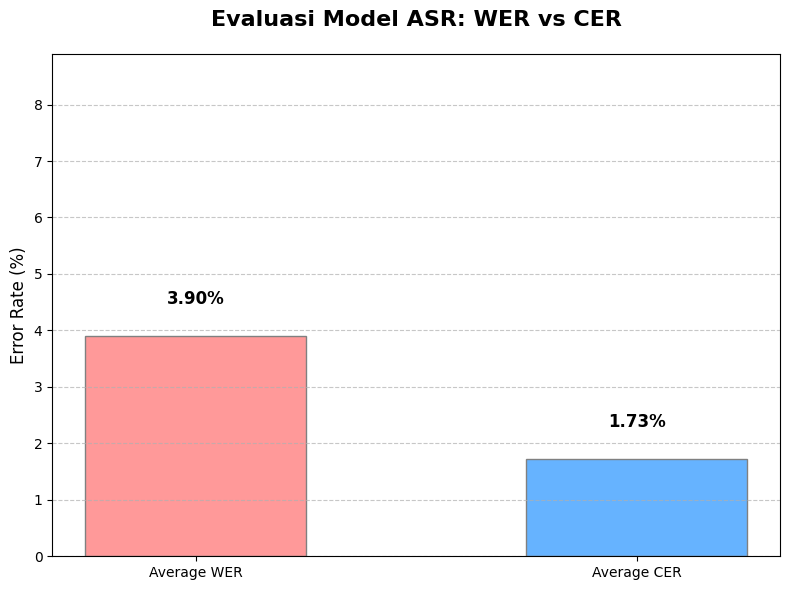

In [23]:
avg_wer = result['Average WER'] * 100 
avg_cer = result['Average CER'] * 100  

categories = ['Average WER', 'Average CER']
values = [avg_wer, avg_cer]
colors = ['#ff9999', '#66b3ff']  

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color=colors, width=0.5, edgecolor='grey')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, 
             f"{yval:.2f}%", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Evaluasi Model ASR: WER vs CER', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.ylim(0, max(values) + 5)  # Beri ruang kosong di atas bar tertinggi
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()